In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from collections import defaultdict
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, KFold

from utils import *

c:\Downloads\[2025] Khóa luận\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel('../dtset.xlsx', sheet_name='filled_data')
df.head()

,bank,quarterly,year,time,NPL,IR,GDP,IIP,INF,CPI,UN,M2,PCR,LTA,ROA,ROE,LDR
0,ABB,1,2012,2012q1,0.0325,0.138700,0.0464,0.0650,0.08,0.1415,0.0222,0.142546,0.0160,0.499451,0.00740,0.065500,0.705935
1,ABB,2,2012,2012q2,0.0325,0.113667,0.0480,0.0802,0.05,0.0690,0.0218,0.142546,0.0153,0.399700,0.00639,0.072606,0.547300
2,ABB,3,2012,2012q3,0.0325,0.092067,0.0505,0.0965,0.04,0.0648,0.0229,0.142546,0.0160,0.499451,0.00740,0.065500,0.705935
3,ABB,4,2012,2012q4,0.0290,0.093667,0.0544,0.0593,0.04,0.0681,0.0212,0.142546,0.0221,0.398600,0.00910,0.083000,0.504700
4,ABB,1,2013,2013q1,0.0325,0.090000,0.0476,0.0516,0.04,0.0664,0.0227,0.142546,0.0221,0.407600,0.00880,0.083000,1.614000


In [3]:
df['time'] = pd.to_datetime(df['year'].astype(str) + '-' + (df['quarterly'] * 3).astype(str) + '-01')
df.set_index(['bank', 'time'], inplace=True)

df.head()

quarterly  year     NPL        IR     GDP     IIP   INF  \
bank time                                                                  
ABB  2012-03-01          1  2012  0.0325  0.138700  0.0464  0.0650  0.08   
     2012-06-01          2  2012  0.0325  0.113667  0.0480  0.0802  0.05   
     2012-09-01          3  2012  0.0325  0.092067  0.0505  0.0965  0.04   
     2012-12-01          4  2012  0.0290  0.093667  0.0544  0.0593  0.04   
     2013-03-01          1  2013  0.0325  0.090000  0.0476  0.0516  0.04   

                    CPI      UN        M2     PCR       LTA      ROA  \
bank time                                                              
ABB  2012-03-01  0.1415  0.0222  0.142546  0.0160  0.499451  0.00740   
     2012-06-01  0.0690  0.0218  0.142546  0.0153  0.399700  0.00639   
     2012-09-01  0.0648  0.0229  0.142546  0.0160  0.499451  0.00740   
     2012-12-01  0.0681  0.0212  0.142546  0.0221  0.398600  0.00910   
     2013-03-01  0.0664  0.0227  0.142546  0.0221  0.407600  0.00880   

                      ROE       LDR  
bank time                            
ABB  2012-03-01  0.065500  0.705935  
     2012-06-01  0.072606  0.547300  
     2012-09-01  0.065500  0.705935  
     2012-12-01  0.083000  0.504700  
     2013-03-01  0.083000  1.614000

In [4]:
df = df.drop(columns=['CPI', 'ROE'], errors='ignore')

df.head()

quarterly  year     NPL        IR     GDP     IIP   INF  \
bank time                                                                  
ABB  2012-03-01          1  2012  0.0325  0.138700  0.0464  0.0650  0.08   
     2012-06-01          2  2012  0.0325  0.113667  0.0480  0.0802  0.05   
     2012-09-01          3  2012  0.0325  0.092067  0.0505  0.0965  0.04   
     2012-12-01          4  2012  0.0290  0.093667  0.0544  0.0593  0.04   
     2013-03-01          1  2013  0.0325  0.090000  0.0476  0.0516  0.04   

                     UN        M2     PCR       LTA      ROA       LDR  
bank time                                                               
ABB  2012-03-01  0.0222  0.142546  0.0160  0.499451  0.00740  0.705935  
     2012-06-01  0.0218  0.142546  0.0153  0.399700  0.00639  0.547300  
     2012-09-01  0.0229  0.142546  0.0160  0.499451  0.00740  0.705935  
     2012-12-01  0.0212  0.142546  0.0221  0.398600  0.00910  0.504700  
     2013-03-01  0.0227  0.142546  0.0221  0.407600  0.00880  1.614000

### Feature Engineering

In [5]:
# Create time feature
df['time_index'] = df.groupby('bank').cumcount()  # time order number

# Create lag features
lags = [1, 2, 3]
lag_vars = ['NPL', 'IR', 'GDP', 'IIP', 'INF', 'PCR', 'M2', 'ROA', 'LTA']
for var in lag_vars:
    for lag in lags:
        df[f'{var}_lag{lag}'] = df.groupby('bank')[var].shift(lag)

# Rolling mean (moving average)
for var in ['NPL']:
    df[f'{var}_roll3'] = df.groupby('bank')[var].rolling(3, min_periods=1).mean().reset_index(0, drop=True)

# Delta (change compared to the previous quarter)
df['delta_NPL'] = df.groupby('bank')['NPL'].diff()

# Data normalization
from sklearn.preprocessing import StandardScaler

exclude_cols = ['bank', 'time', 'year', 'quarterly', 'NPL']
features_to_scale = [col for col in df.columns if col not in exclude_cols and df[col].dtype != 'object']

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Assign input features for the model
feature_cols = [col for col in df.columns if col not in exclude_cols]

In [6]:
df.head()

quarterly  year     NPL        IR       GDP       IIP  \
bank time                                                                
ABB  2012-03-01          1  2012  0.0325  3.608049 -0.865141 -0.231633   
     2012-06-01          2  2012  0.0325  2.511177 -0.765161  0.203668   
     2012-09-01          3  2012  0.0325  1.564742 -0.608943  0.670472   
     2012-12-01          4  2012  0.0290  1.634848 -0.365244 -0.394871   
     2013-03-01          1  2013  0.0325  1.474188 -0.790156 -0.615385   

                      INF        UN            M2       PCR  ...   M2_lag2  \
bank time                                                    ...             
ABB  2012-03-01  4.049798 -0.308747 -4.221249e-09  0.393865  ...       NaN   
     2012-06-01  1.880795 -0.430574 -4.221249e-09  0.249120  ...       NaN   
     2012-09-01  1.157794 -0.095550 -4.221249e-09  0.393865  ... -0.020512   
     2012-12-01  1.157794 -0.613314 -4.221249e-09  1.655208  ... -0.020512   
     2013-03-01  1.157794 -0.156464 -4.221249e-09  1.655208  ... -0.020512   

                  M2_lag3  ROA_lag1  ROA_lag2  ROA_lag3  LTA_lag1  LTA_lag2  \
bank time                                                                     
ABB  2012-03-01       NaN       NaN       NaN       NaN       NaN       NaN   
     2012-06-01       NaN  -0.35347       NaN       NaN -1.000135       NaN   
     2012-09-01       NaN  -0.48159 -0.344187       NaN -1.981898 -0.984687   
     2012-12-01 -0.038387  -0.35347 -0.472075 -0.335030 -1.000135 -1.961348   
     2013-03-01 -0.038387  -0.13778 -0.344187 -0.462752 -1.992725 -0.984687   

                 LTA_lag3  NPL_roll3  delta_NPL  
bank time                                        
ABB  2012-03-01       NaN   0.824013        NaN  
     2012-06-01       NaN   0.824013  -0.004742  
     2012-09-01       NaN   0.824013  -0.004742  
     2012-12-01 -0.970657   0.725269  -0.407396  
     2013-03-01 -1.942452   0.725269   0.397912  

[5 rows x 43 columns]

### Train - Test

In [7]:
df.reset_index(inplace=True)
df = df.sort_values(by="time")

split_date = pd.to_datetime("2022-04-01")  # Q2/2022

train_df = df[df['time'] < split_date]
test_df = df[df['time'] >= split_date]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")

Train size: (943, 45), Test size: (230, 45)


In [8]:
train_df.head()

,bank,time,quarterly,year,NPL,IR,GDP,IIP,INF,UN,...,M2_lag2,M2_lag3,ROA_lag1,ROA_lag2,ROA_lag3,LTA_lag1,LTA_lag2,LTA_lag3,NPL_roll3,delta_NPL
0,ABB,2012-03-01,1,2012,0.0325,3.608049,-0.865141,-0.231633,4.049798,-0.308747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.824013,NaN
561,OCB,2012-03-01,1,2012,0.0236,3.608049,-0.865141,-0.231633,4.049798,-0.308747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070737,NaN
714,SHB,2012-03-01,1,2012,0.0247,3.608049,-0.865141,-0.231633,4.049798,-0.308747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.163839,NaN
1020,VCB,2012-03-01,1,2012,0.0295,3.608049,-0.865141,-0.231633,4.049798,-0.308747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.570100,NaN
153,BID,2012-03-01,1,2012,0.0299,3.608049,-0.865141,-0.231633,4.049798,-0.308747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.603955,NaN


In [9]:
test_df.head()

,bank,time,quarterly,year,NPL,IR,GDP,IIP,INF,UN,...,M2_lag2,M2_lag3,ROA_lag1,ROA_lag2,ROA_lag3,LTA_lag1,LTA_lag2,LTA_lag3,NPL_roll3,delta_NPL
41,ABB,2022-06-01,2,2022,0.0233,-1.334863,1.059464,0.512961,-0.302668,-0.00418,...,-0.974005,-0.600542,0.357037,0.377701,0.613580,-0.357944,-0.355625,-0.208338,0.059452,-0.016246
194,BID,2022-06-01,2,2022,0.0106,-1.334863,1.059464,0.512961,-0.302668,-0.00418,...,-0.974005,-0.600542,-0.454970,-0.470834,-0.486808,1.447105,1.491937,1.664116,-1.060588,0.075789
653,PGB,2022-06-01,2,2022,0.0270,-1.334863,1.059464,0.512961,-0.302668,-0.00418,...,-0.974005,-0.600542,-0.290031,-0.432840,-0.297086,0.626270,0.710615,0.909094,0.268225,0.190833
806,SSB,2022-06-01,2,2022,0.0163,-1.334863,1.059464,0.512961,-0.302668,-0.00418,...,-0.974005,-0.600542,0.610790,0.403031,0.411210,0.204042,-0.055041,-0.355445,-0.527370,-0.039255
1163,VPB,2022-06-01,2,2022,0.0543,-1.334863,1.059464,0.512961,-0.302668,-0.00418,...,-0.974005,-0.600542,2.996062,1.796148,2.207245,0.418601,0.303310,0.484333,2.339029,0.501452


In [10]:
train_df = train_df.set_index(['bank', 'time'])
test_df = test_df.set_index(['bank', 'time'])

train_df = train_df.drop(columns=["quarterly", "year"])
test_df = test_df.drop(columns=["quarterly", "year"])

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [11]:
train_df.head()

,,NPL,IR,GDP,IIP,INF,UN,M2,PCR,LTA,ROA,...,M2_lag2,M2_lag3,ROA_lag1,ROA_lag2,ROA_lag3,LTA_lag1,LTA_lag2,LTA_lag3,NPL_roll3,delta_NPL
bank,time,,,,,,,,,,,,,,,,,,,,,
ABB,2012-03-01,0.0325,3.608049,-0.865141,-0.231633,4.049798,-0.308747,-4.221249e-09,0.393865,-1.015418,-0.362059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.824013,0.0
OCB,2012-03-01,0.0236,3.608049,-0.865141,-0.231633,4.049798,-0.308747,-4.221249e-09,-0.702057,-0.276536,0.400996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070737,0.0
SHB,2012-03-01,0.0247,3.608049,-0.865141,-0.231633,4.049798,-0.308747,-4.221249e-09,-0.143757,-1.813629,0.222950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.163839,0.0
VCB,2012-03-01,0.0295,3.608049,-0.865141,-0.231633,4.049798,-0.308747,-4.221249e-09,2.999263,-0.382303,0.184797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570100,0.0
BID,2012-03-01,0.0299,3.608049,-0.865141,-0.231633,4.049798,-0.308747,-4.221249e-09,0.621320,1.198283,-0.387494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.603955,0.0


In [12]:
def run_lstm_models(train_df, test_df, epochs=50, batch_size=16, verbose=0):
    def build_lstm(input_shape):
        model = Sequential([
            LSTM(50, activation='relu', return_sequences=False, input_shape=input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    dl_results = {}
    eval_results = []

    for bank in train_df.index.get_level_values('bank').unique():
        train_y = train_df.xs(bank, level='bank')['NPL']
        test_y = test_df.xs(bank, level='bank')['NPL']

        train_x_df = train_df.xs(bank, level='bank').drop(columns=['NPL'])
        test_x_df = test_df.xs(bank, level='bank').drop(columns=['NPL'])

        train_x = train_x_df.values.reshape(-1, train_x_df.shape[1], 1)
        test_x = test_x_df.values.reshape(-1, test_x_df.shape[1], 1)

        model = build_lstm((train_x.shape[1], 1))
        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        predictions = model.predict(test_x)

        preds_series = pd.Series(predictions.ravel(), index=test_y.index)
        bank_eval = list(evaluate(test_y, preds_series, "LSTM", bank))
        eval_results.append(bank_eval)

        plot_results(test_y, predictions, "LSTM", bank)
        dl_results[bank] = model

    return dl_results, eval_results

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0077
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9399e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2843e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.3724e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0647e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8405e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2693e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5977e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.0995e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9362e-05
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6033e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0564e-05
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 

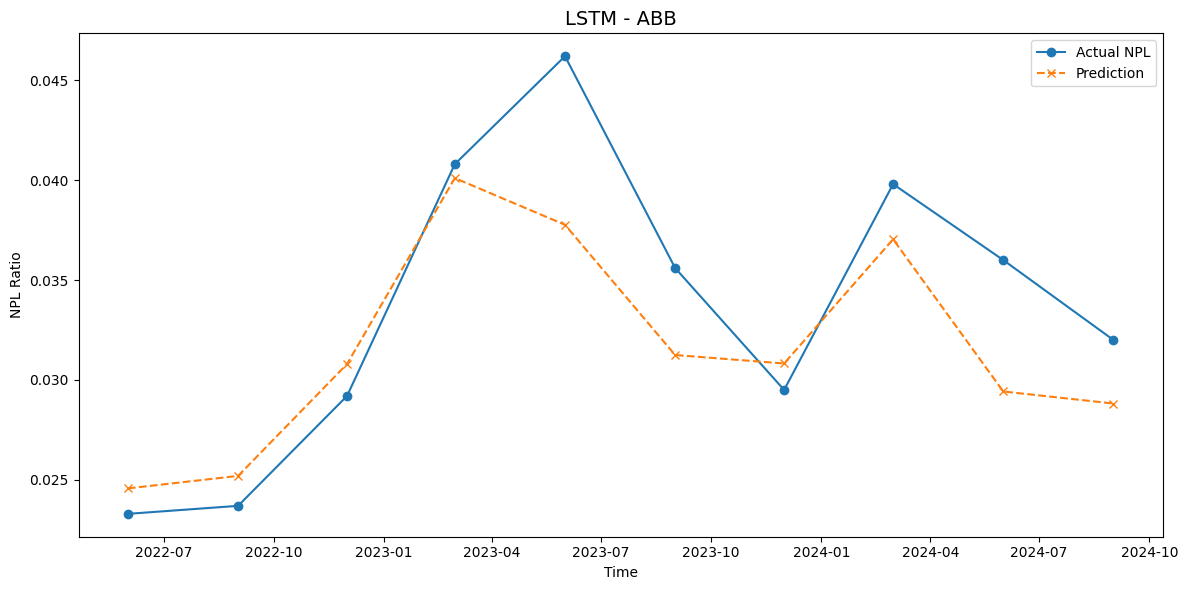

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2209e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1826e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3301e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7104e-05
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0666e-05
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5838e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1902e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8142e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4494e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5168e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6753e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.2658e-06
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4444e-06
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1801e-06
Epoch 15/100
6/6 ━━━━━━━━━━━━

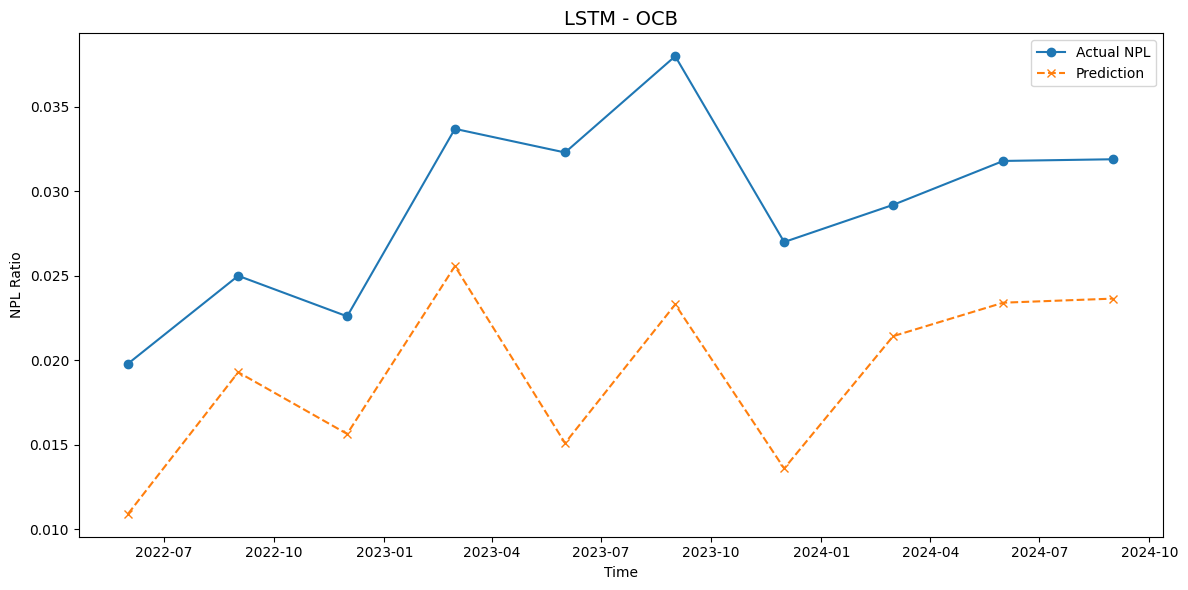

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2021e-04 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1688e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7010e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5715e-04 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7004e-04 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7490e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0190e-04
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6537e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.8381e-05
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8779e-05
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8244e-05
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s

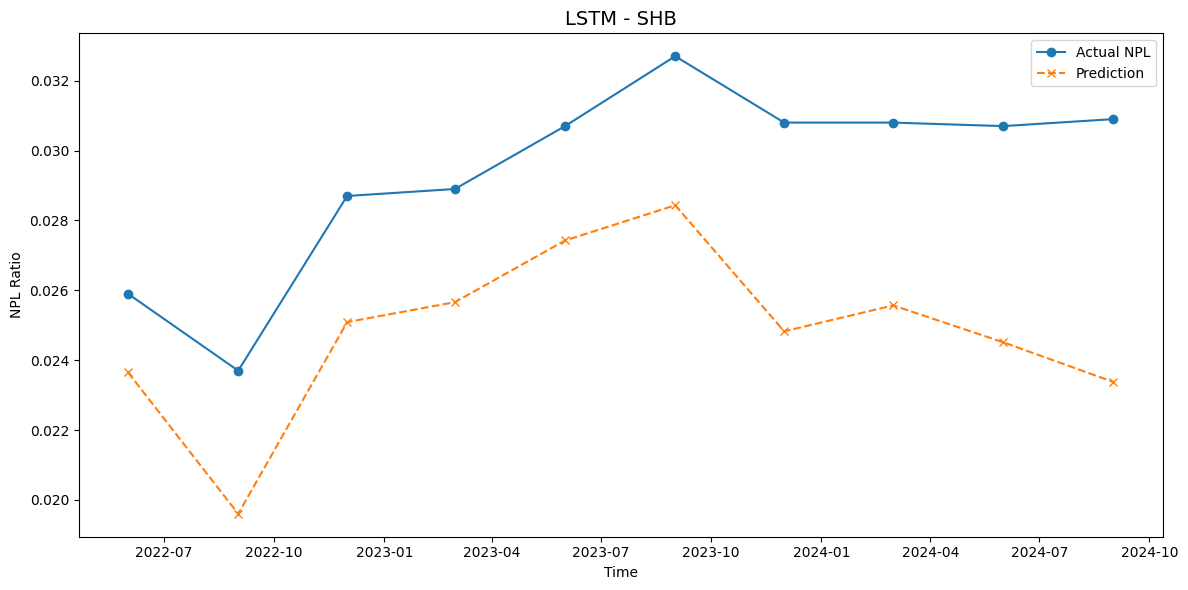

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.3069e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4660e-04 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3402e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1534e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9112e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8652e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4535e-04 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0272e-04
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1630e-04
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4330e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0546e-05 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5824e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0301e-05
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━

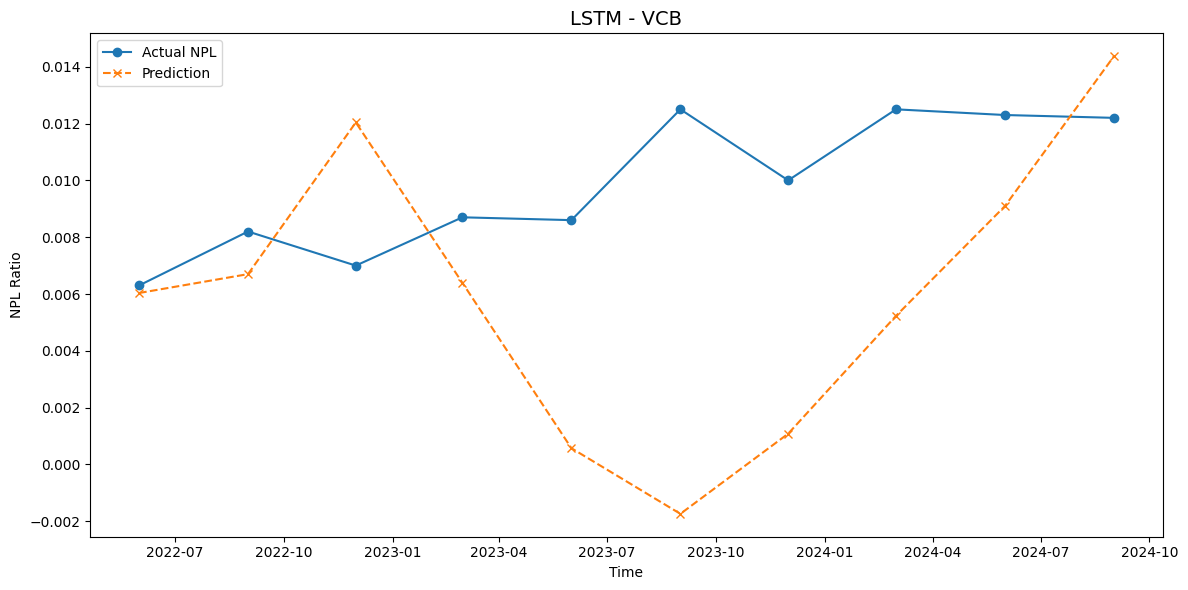

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2137e-04 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1842e-05
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1899e-05 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0166e-05 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7755e-05
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1818e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2345e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1835e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0695e-05 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6837e-06
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4002e-06
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8764e-06
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2638e-06 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4702e-06
Epoch 15/100
6/6 ━━━━━━━━━━━

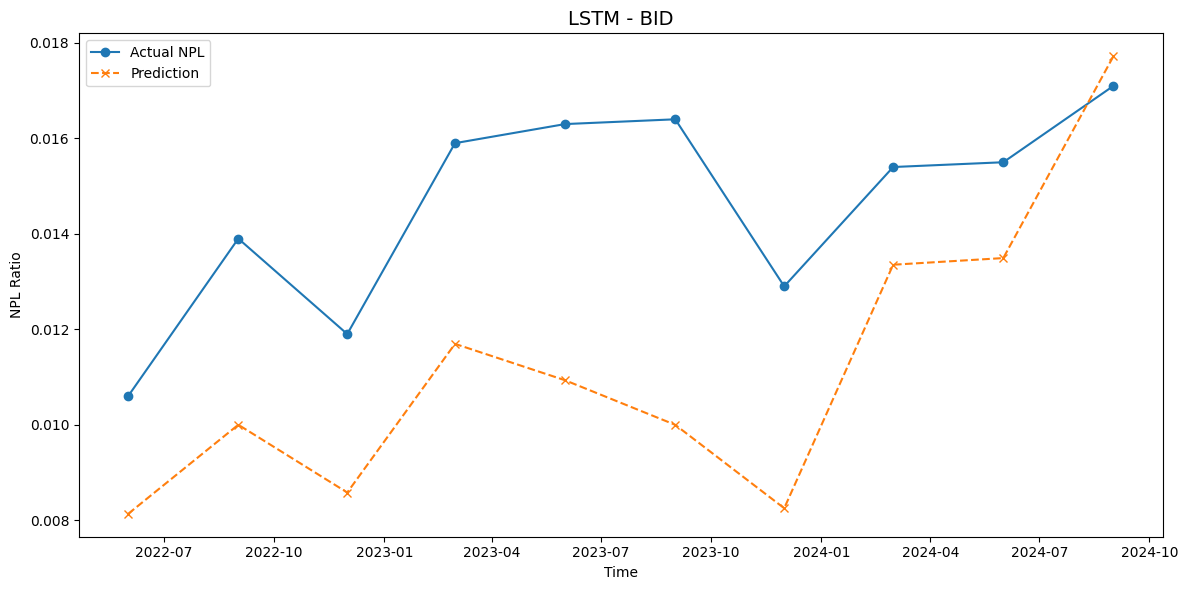

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018  
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3699e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2733e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0337e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9834e-05
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0801e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3025e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4131e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9551e-05 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8702e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6938e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3393e-05
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.7354e-06
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0603e-06 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━

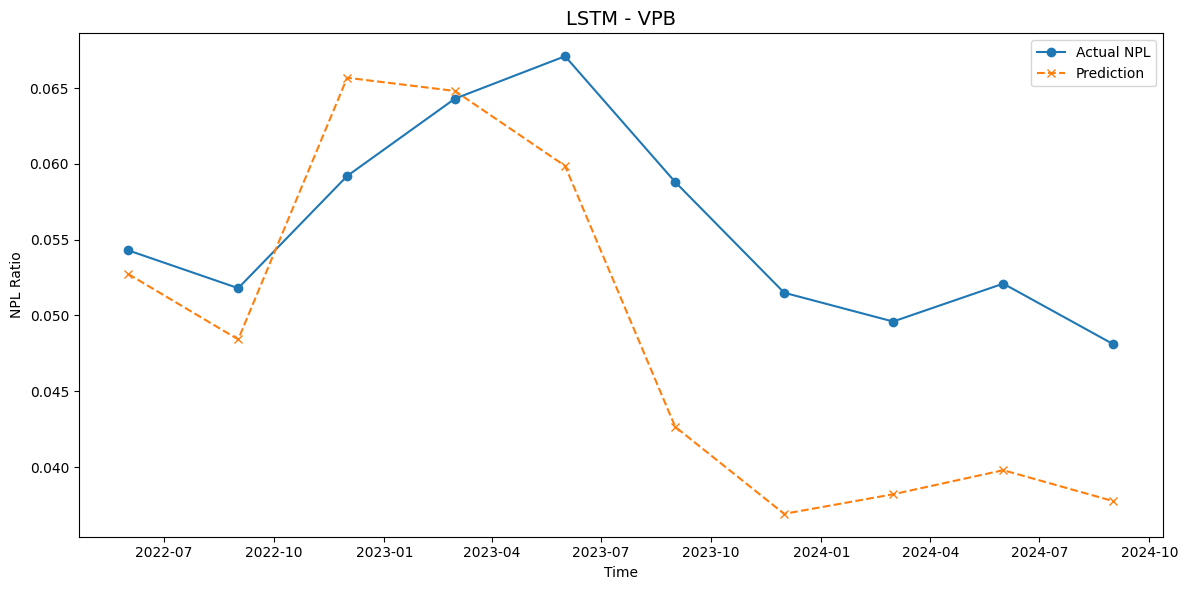

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2800e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3163e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9901e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7729e-04 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4617e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2173e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4685e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7284e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4247e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2846e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7377e-05 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3699e-05
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1710e-05 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━

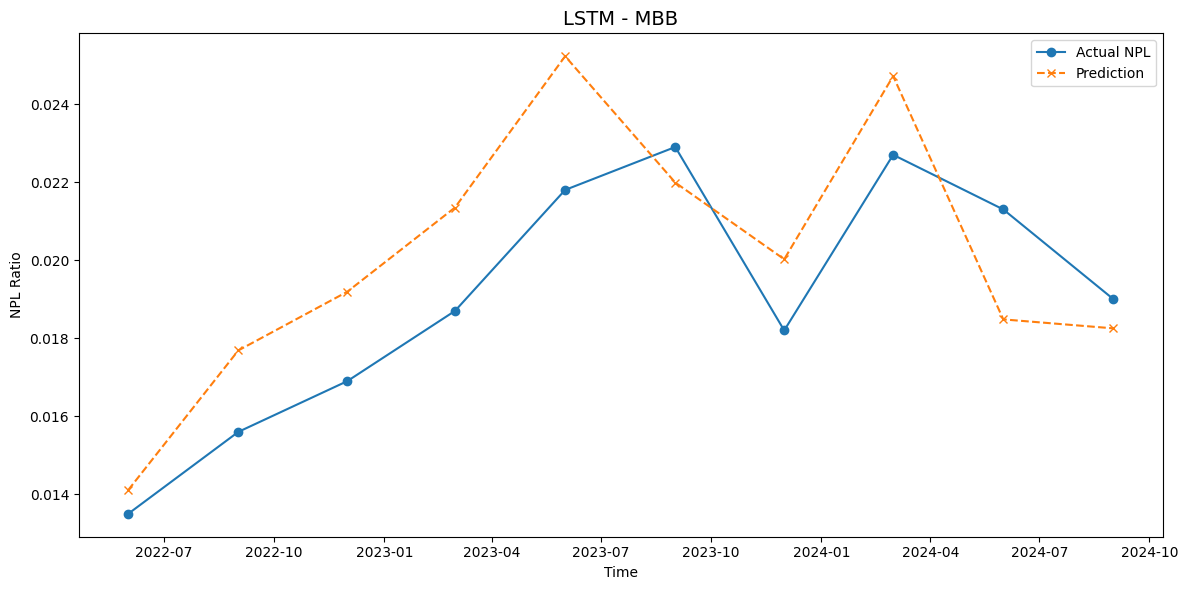

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0096  
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011     
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8938e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3203e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0265e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3465e-04 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0306e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8278e-04
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4456e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2882e-05 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5857e-05
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1471e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4008e-05
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━

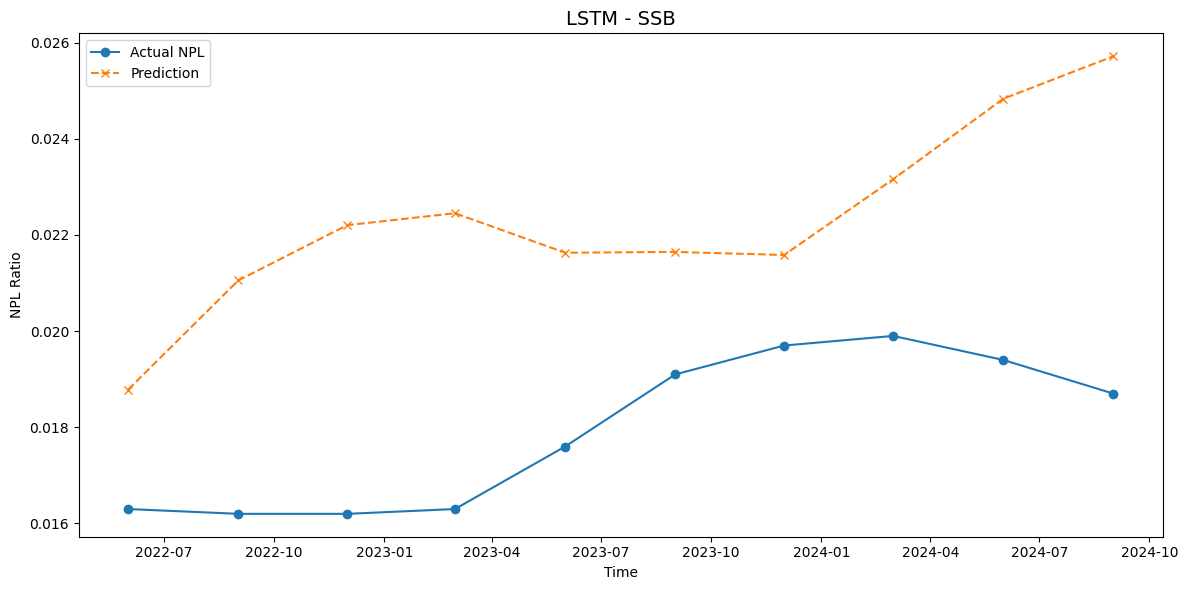

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0221e-04 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5128e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0580e-04 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3728e-05 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.1729e-05
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2214e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8425e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6132e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5011e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7803e-05 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9818e-05 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2963e-05 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4880e-05
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9830e-05
Epoch 15/100
6/6 ━━━━━━━━━━━

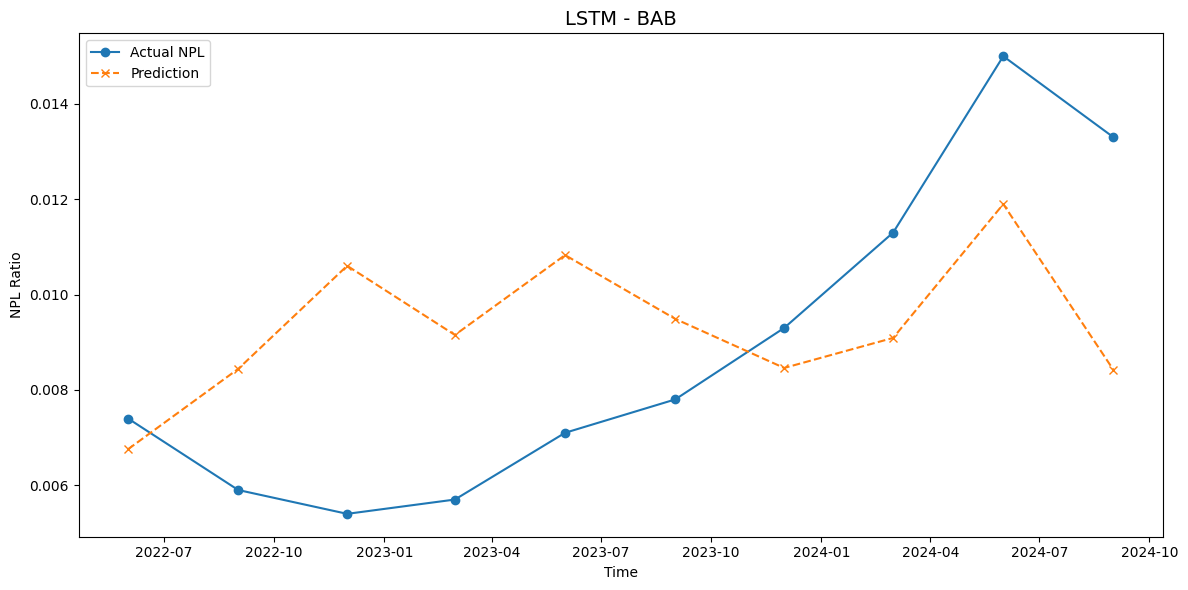

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5101e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.6283e-05
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8312e-05 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9813e-05
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1799e-05 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7549e-05 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6439e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8390e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4539e-05 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8624e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1055e-05 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0743e-05
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7623e-06
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4444e-05
Epoch 15/100
6/6 ━━━━━━━━━━━━

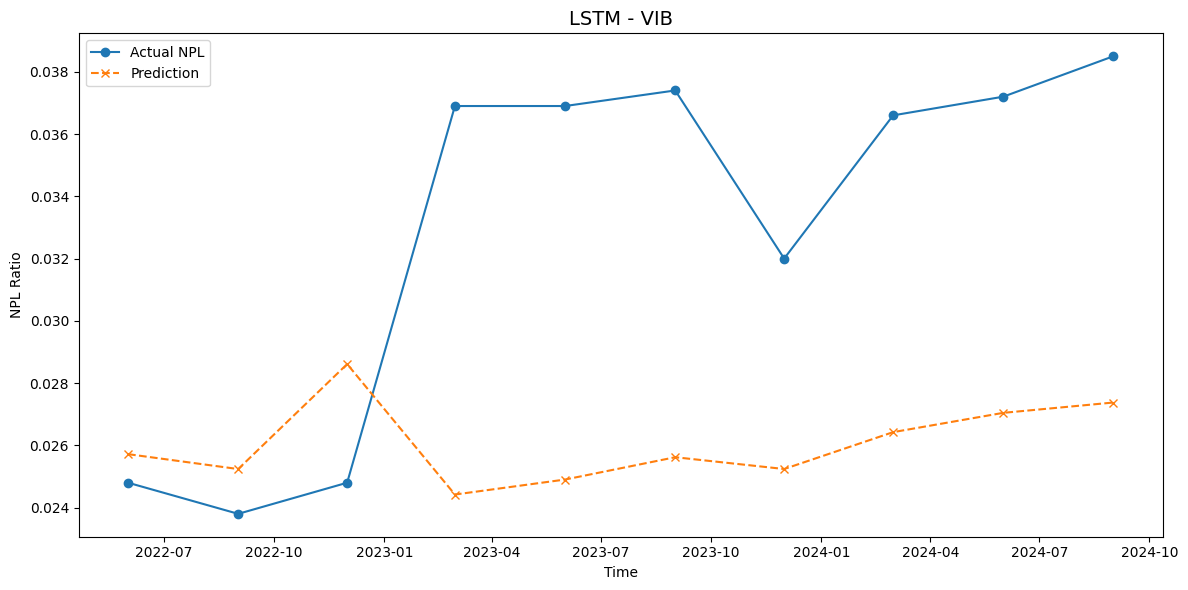

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.3060e-04 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4454e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4689e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0200e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0325e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5013e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4038e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1815e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5221e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6446e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7596e-05 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1185e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9178e-05
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━

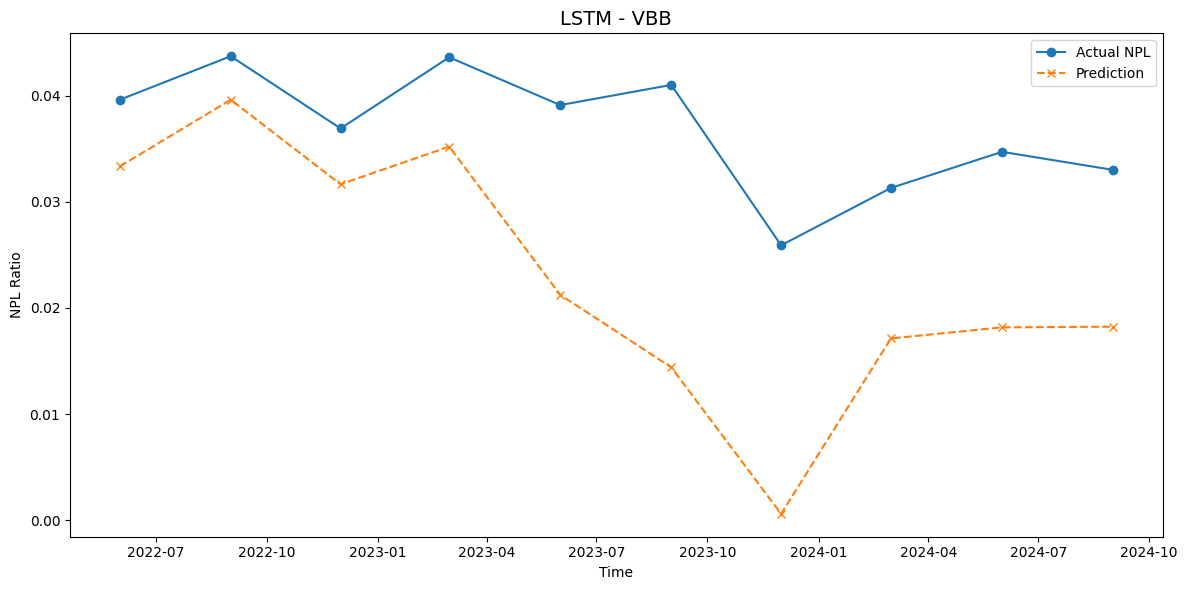

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1204e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7306e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8092e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2781e-04 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6442e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3040e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4028e-04 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7986e-04
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4681e-04
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0302e-04
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4520e-04 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6471e-04 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━

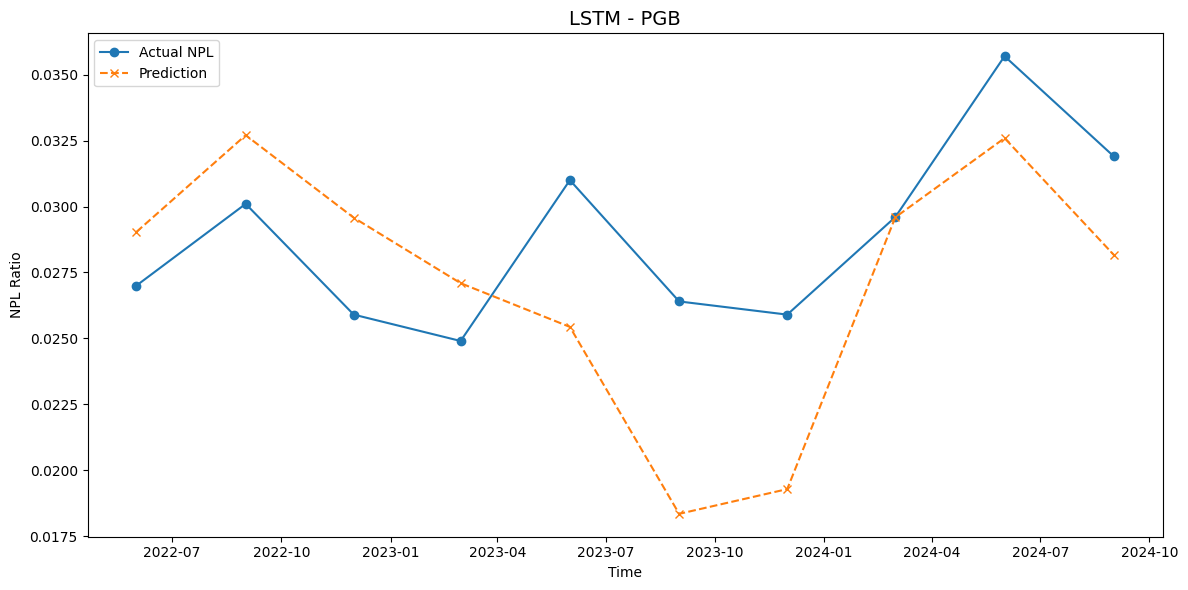

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0066 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2036e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4659e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7053e-04 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0213e-05
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8263e-04 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7800e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8199e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1926e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0183e-05 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6350e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0430e-05
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6186e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8385e-05
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━

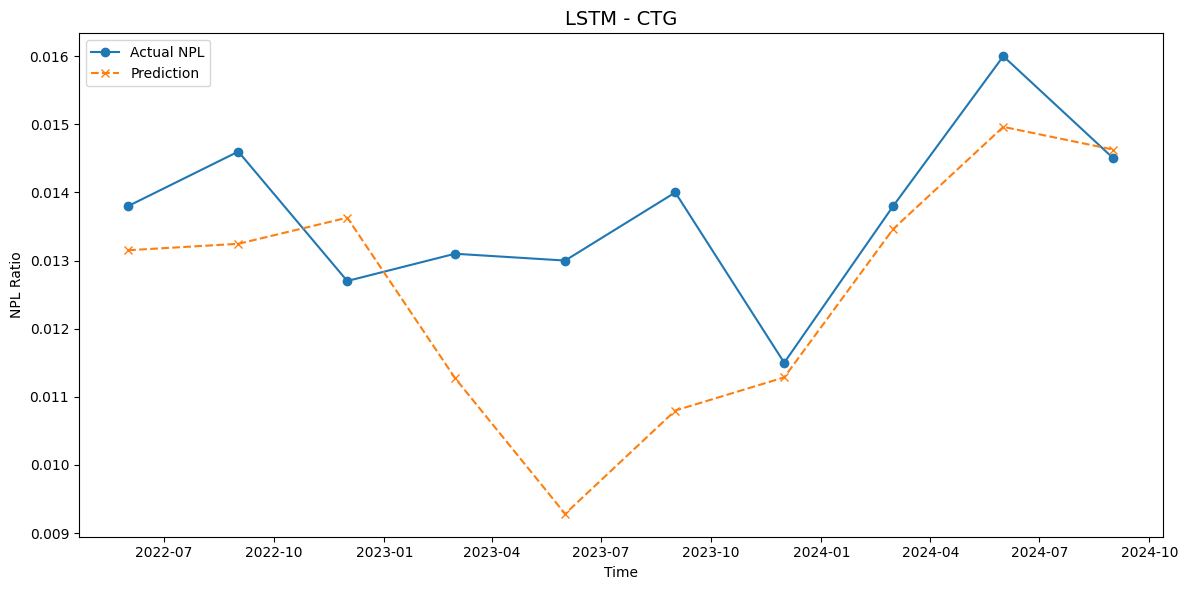

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0301
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013     
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0138e-04 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010     
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3403e-04
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.0642e-04
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5084e-04 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1055e-04 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2607e-04
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

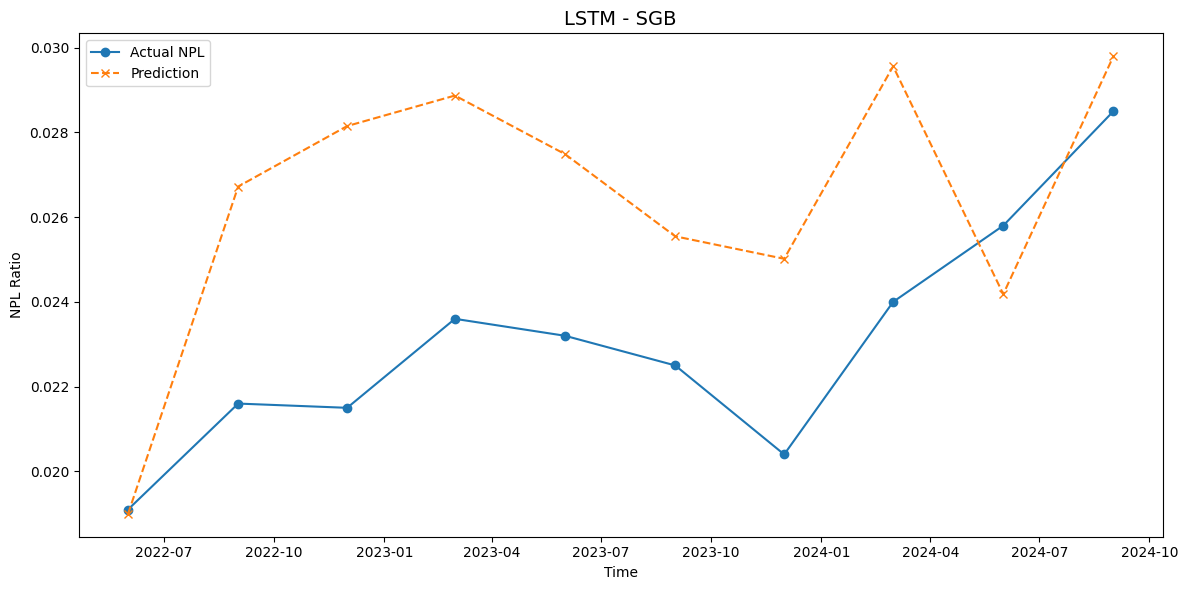

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036  
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015     
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7770e-04 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0504e-04 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6321e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6661e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.6191e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5450e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5123e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9874e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6334e-05 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2271e-05
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1609e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9150e-05 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━

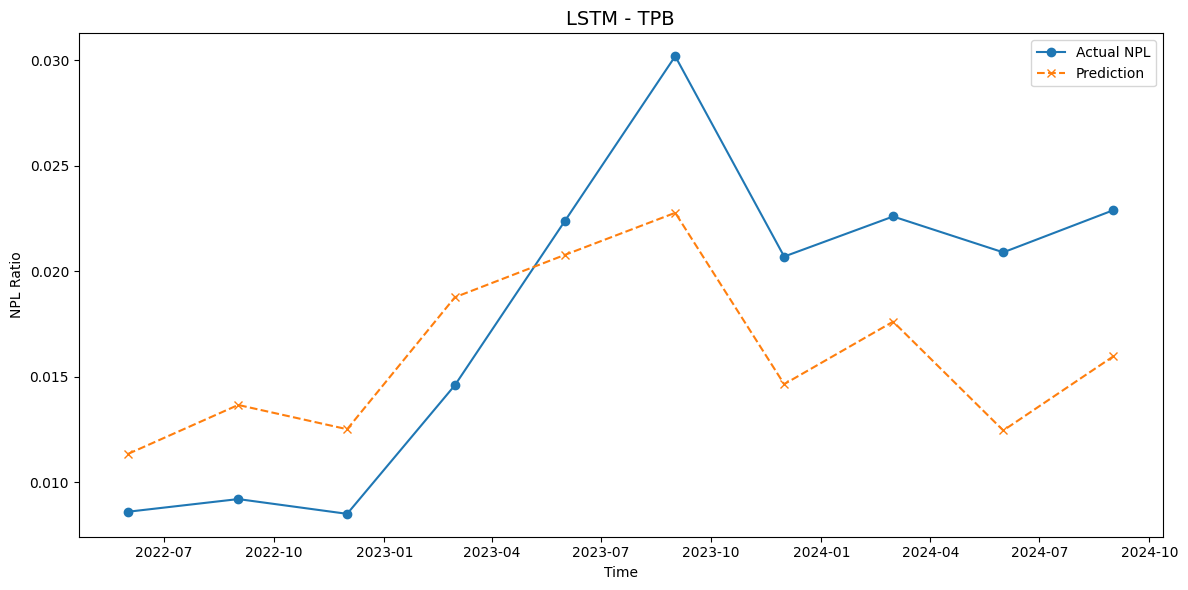

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.7276e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8590e-04 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3499e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4542e-05 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7294e-05
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3462e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9241e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6758e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2692e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2110e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3583e-06 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3823e-05 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0969e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3345e-06 
Epoch 15/100
6/6 ━━━━━━━━━━━━━

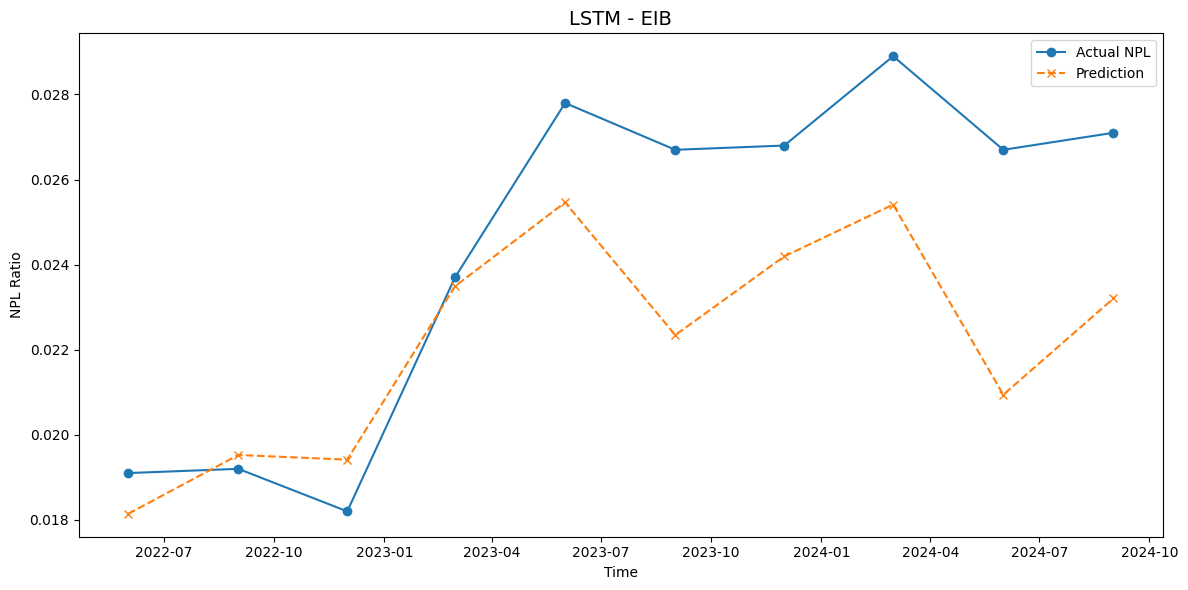

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.8085e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2798e-04 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.3911e-05 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9142e-05
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0831e-05 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9858e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3021e-05 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1008e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6433e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3929e-05 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9262e-05 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5964e-05 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0621e-05
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7149e-05 
Epoch 15/100
6/6 ━━━━━━━━━━━━

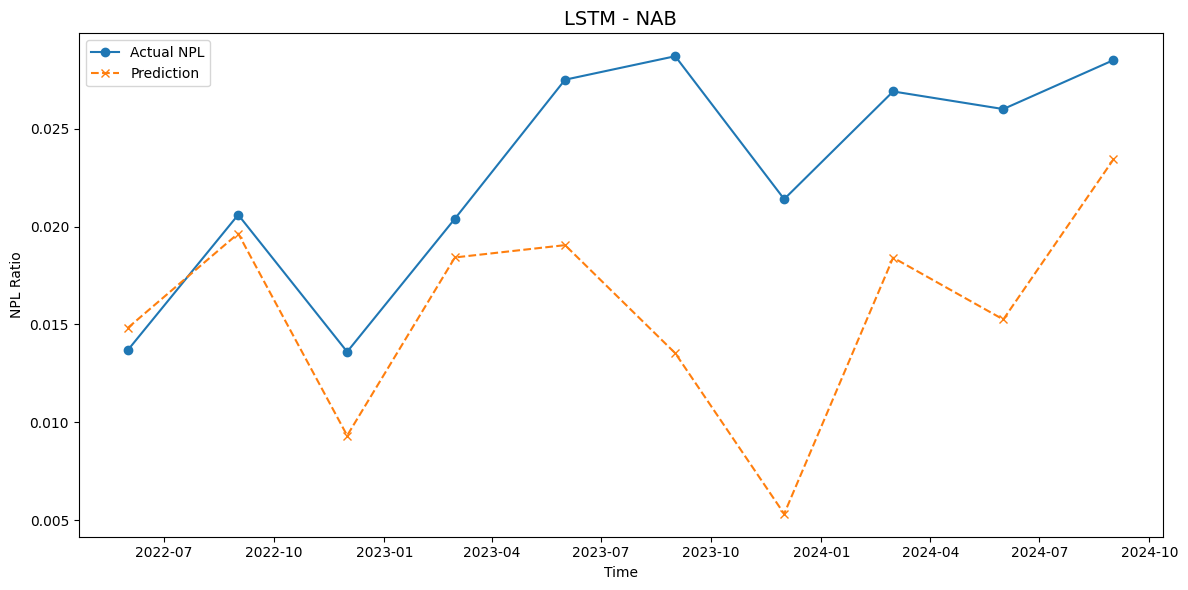

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.2659e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4874e-04 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9642e-04 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3310e-05
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0355e-04 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0832e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5774e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7101e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3418e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3283e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2868e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7818e-05
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0574e-05
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1857e-05 
Epoch 15/100
6/6 ━━━━━━━━━━━━

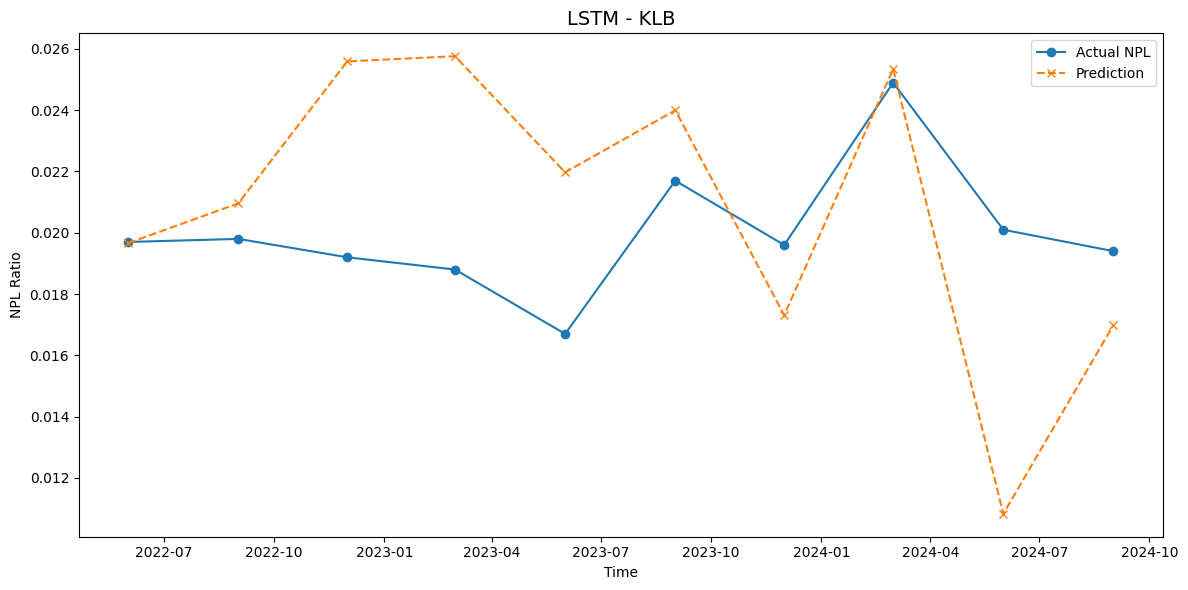

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0110 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.2025e-04 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9325e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5087e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5813e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2713e-04 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9462e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1565e-04 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0483e-04 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3132e-04 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1687e-04
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4172e-05
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.7433e-05 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━

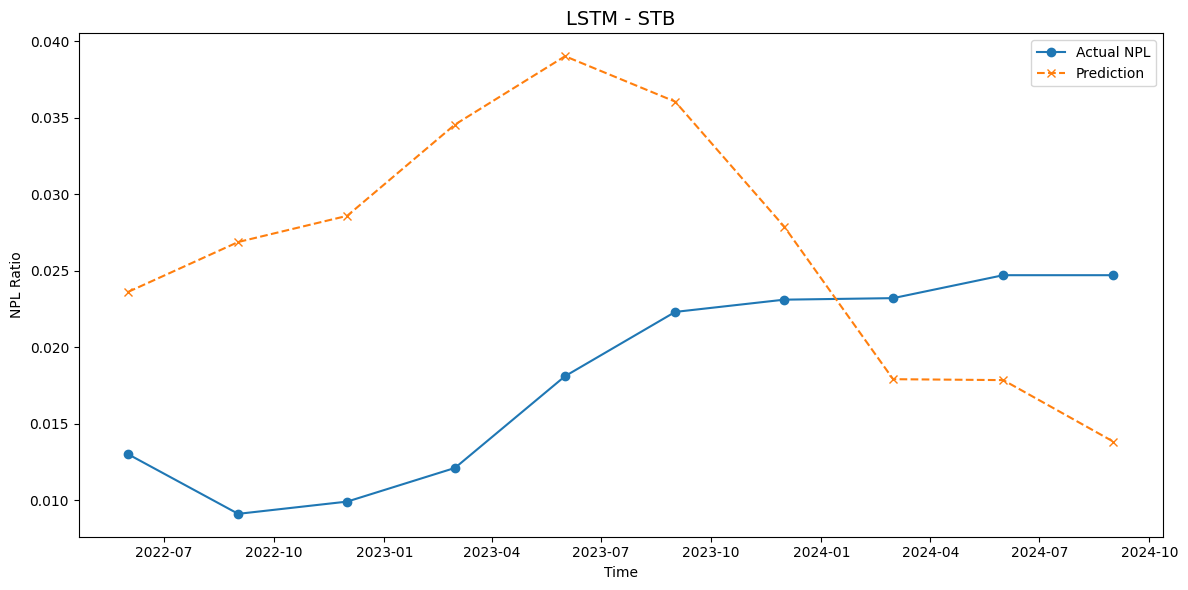

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.8862e-04 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7687e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4518e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9257e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5860e-04 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4041e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3348e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9442e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9647e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7927e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5258e-05
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5607e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5026e-05 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━

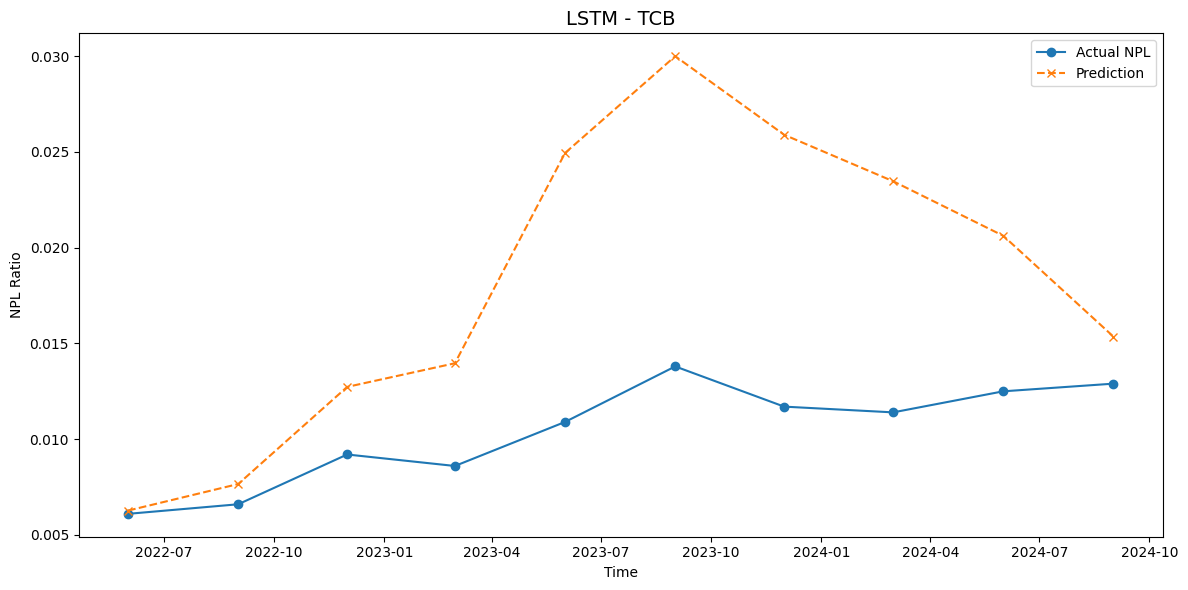

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7857e-04 
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6971e-05
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3009e-05 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6715e-05
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2155e-05 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1906e-05 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0864e-05
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9118e-05
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6191e-05
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8524e-05
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6741e-05 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6662e-05 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0199e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0682e-05
Epoch 15/100
6/6 ━━━━━━━━━━━

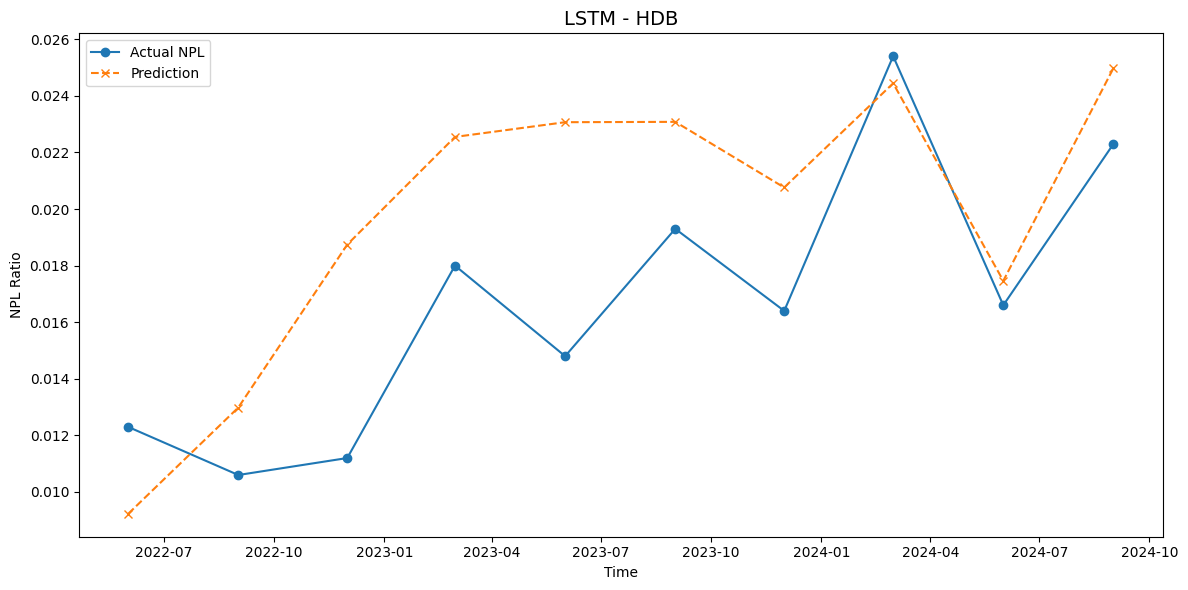

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3704e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2019e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.1307e-05
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0084e-05
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6104e-05
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9132e-05
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9667e-05 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2346e-05 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5337e-05 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4201e-05 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8132e-05
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3560e-05 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4965e-05 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8679e-05
Epoch 15/100
6/6 ━━━━━━━━━━━━

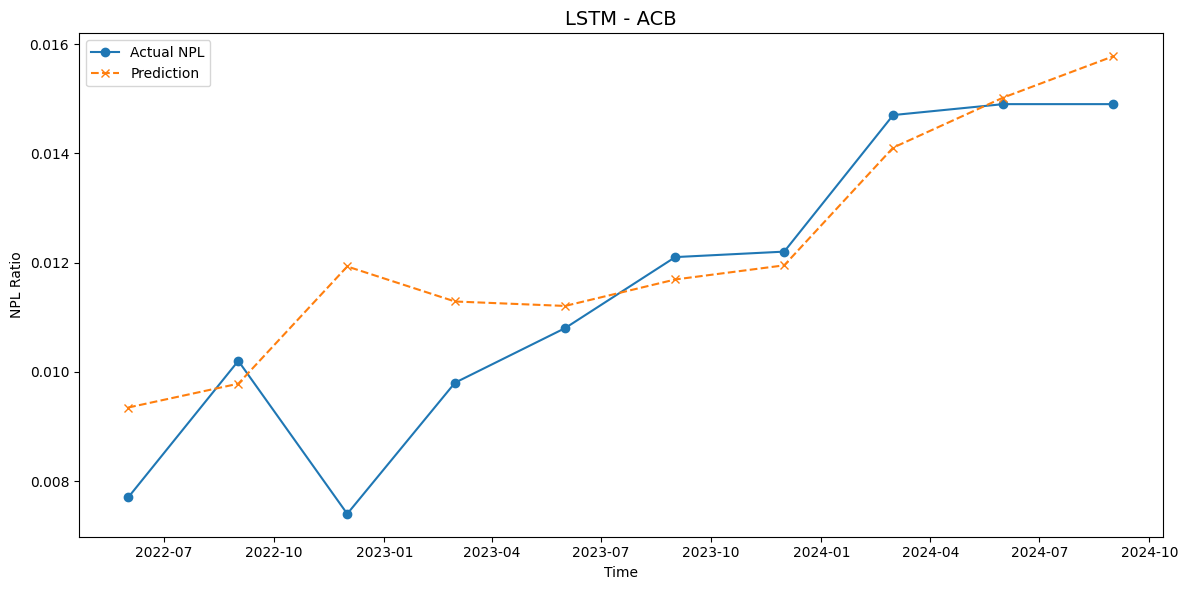

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2236e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8860e-04 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7200e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5897e-04 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4405e-05 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6317e-05 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3519e-05 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8002e-05 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4077e-05 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0482e-05 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3107e-05 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8466e-05 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4370e-05
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4115e-05
Epoch 15/100
6/6 ━━━━━━━━━━━━

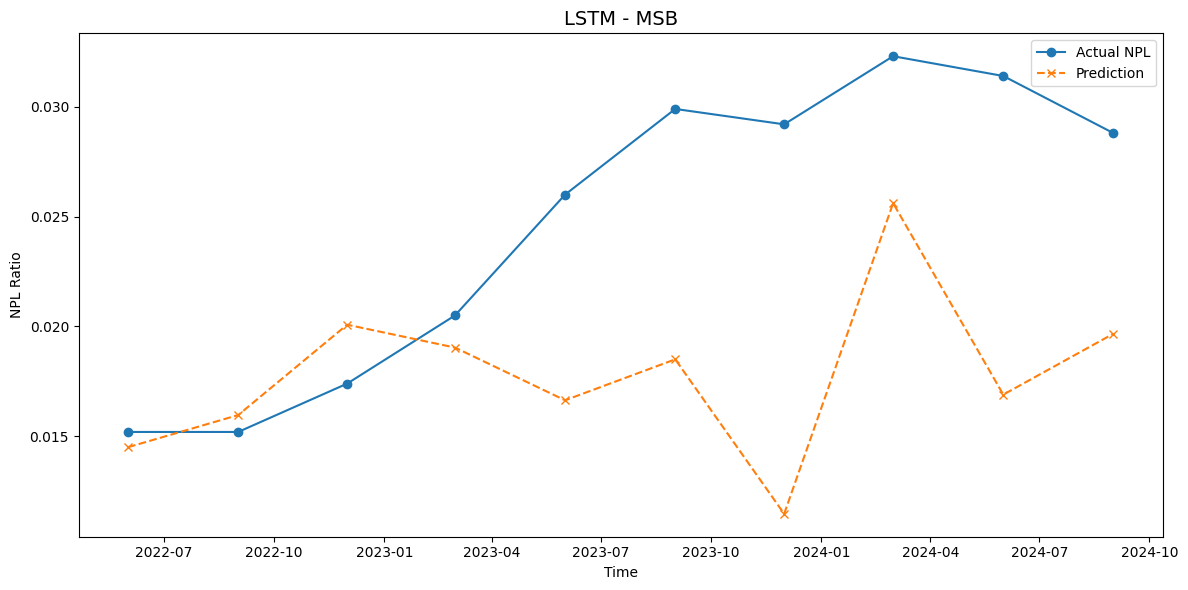

In [13]:
dl_models, eval_results = run_lstm_models(train_df, test_df, epochs=100, batch_size=8, verbose=1)

In [14]:
dl_results_df = pd.DataFrame(eval_results, columns=["Bank", "Model", "MAE", "MSE", "RMSE", 'R2', 'SMAPE', 'MASE'])

dl_results_df 

,Bank,Model,MAE,MSE,RMSE,R2,SMAPE,MASE
0,ABB,LSTM,0.003170,0.000016,0.003997,0.681485,9.375620,0.494427
1,OCB,LSTM,0.009941,0.000112,0.010568,-3.050898,42.494847,2.145618
2,SHB,LSTM,0.004565,0.000023,0.004819,-2.523028,16.869090,3.066071
3,VCB,LSTM,0.005293,0.000045,0.006689,-7.617817,77.206656,3.378588
4,BID,LSTM,0.003499,0.000015,0.003874,-2.556875,28.546581,1.799585
5,VPB,LSTM,0.008394,0.000097,0.009849,-1.632384,17.387350,1.807250
6,MBB,LSTM,0.001938,0.000005,0.002132,0.488970,9.772578,0.782075
7,SSB,LSTM,0.004366,0.000022,0.004682,-8.724887,21.669094,7.858549
8,BAB,LSTM,0.002829,0.000010,0.003188,-0.010318,31.633210,1.914433
9,VIB,LSTM,0.008064,0.000083,0.009122,-1.516598,26.199108,2.738766


In [15]:
top5 = get_top_banks(dl_results_df, metric="MASE", top_n=5)
top5

,Bank,Model,MAE,MSE,RMSE,R2,SMAPE,MASE
0,ABB,LSTM,0.003170,0.000016,0.003997,0.681485,9.375620,0.494427
21,ACB,LSTM,0.001074,0.000003,0.001647,0.615252,10.432424,0.755070
6,MBB,LSTM,0.001938,0.000005,0.002132,0.488970,9.772578,0.782075
20,HDB,LSTM,0.003846,0.000020,0.004508,0.013641,22.680169,0.801180
12,CTG,LSTM,0.001339,0.000003,0.001783,-1.346906,10.771186,0.949235


In [16]:
best_model = dl_results_df.sort_values(by=["Bank", "MASE"]).groupby("Bank").first().reset_index()
best_model

,Bank,Model,MAE,MSE,RMSE,R2,SMAPE,MASE
0,ABB,LSTM,0.003170,0.000016,0.003997,0.681485,9.375620,0.494427
1,ACB,LSTM,0.001074,0.000003,0.001647,0.615252,10.432424,0.755070
2,BAB,LSTM,0.002829,0.000010,0.003188,-0.010318,31.633210,1.914433
3,BID,LSTM,0.003499,0.000015,0.003874,-2.556875,28.546581,1.799585
4,CTG,LSTM,0.001339,0.000003,0.001783,-1.346906,10.771186,0.949235
5,EIB,LSTM,0.002515,0.000009,0.003070,0.369572,10.342952,1.363346
6,HDB,LSTM,0.003846,0.000020,0.004508,0.013641,22.680169,0.801180
7,KLB,LSTM,0.003654,0.000022,0.004701,-4.453419,19.040586,1.558740
8,MBB,LSTM,0.001938,0.000005,0.002132,0.488970,9.772578,0.782075
9,MSB,LSTM,0.007440,0.000088,0.009383,-1.097414,33.024503,3.043685


### Tuning

In [17]:
def tune_lstm_model(train_x, train_y, n_trials=30):
    def objective(trial):
        n_units = trial.suggest_int('n_units', 16, 128, step=16)
        n_layers = trial.suggest_int('n_layers', 1, 3)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

        model = Sequential()
        for i in range(n_layers):
            return_sequences = i < n_layers - 1
            if i == 0:
                model.add(LSTM(n_units, return_sequences=return_sequences, input_shape=(train_x.shape[1], train_x.shape[2])))
            else:
                model.add(LSTM(n_units, return_sequences=return_sequences))
            model.add(Dropout(dropout_rate))
        
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

        history = model.fit(train_x, train_y, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
        return min(history.history['val_loss'])

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

In [18]:
best_params_dict = {}

for bank in train_df.index.get_level_values('bank').unique():
    train_y = train_df.xs(bank, level='bank')['NPL']
    train_x_df = train_df.xs(bank, level='bank').drop(columns=['NPL'])
    train_x = train_x_df.values.reshape(-1, train_x_df.shape[1], 1)

    print(f"🔧 Tuning hyperparameters for {bank}...")
    best_params = tune_lstm_model(train_x, train_y, n_trials=10)
    best_params_dict[bank] = best_params
    print(f"Best parameters for {bank}: {best_params}\n")


[I 2025-04-18 19:31:11,162] A new study created in memory with name: no-name-dc916d1b-49a6-418c-81e6-2ee7559e5f41


🔧 Tuning hyperparameters for ABB...


C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:31:14,402] Trial 0 finished with value: 0.00010207707236986607 and parameters: {'n_units': 128, 'n_layers': 2, 'dropout_rate': 0.3693941100455054, 'learning_rate': 0.0002462657537249584}. Best is trial 0 with value: 0.00010207707236986607.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:31:16,486] Trial 1 finished with value

Best parameters for ABB: {'n_units': 16, 'n_layers': 3, 'dropout_rate': 0.27245303473293925, 'learning_rate': 0.002937242007874697}

🔧 Tuning hyperparameters for OCB...


[I 2025-04-18 19:31:44,435] Trial 0 finished with value: 4.172074477537535e-05 and parameters: {'n_units': 64, 'n_layers': 3, 'dropout_rate': 0.11175727981930361, 'learning_rate': 0.0022710106024110277}. Best is trial 0 with value: 4.172074477537535e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:31:46,451] Trial 1 finished with value: 1.4318245121103246e-05 and parameters: {'n_units': 96, 'n_layers': 1, 'dropout_rate': 0.15482032273111468, 'learning_rate': 0.0011741469572844154}. Best is trial 1 with value: 1.4318245121103246e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature

Best parameters for OCB: {'n_units': 96, 'n_layers': 1, 'dropout_rate': 0.15482032273111468, 'learning_rate': 0.0011741469572844154}

🔧 Tuning hyperparameters for SHB...


[I 2025-04-18 19:32:14,050] Trial 0 finished with value: 1.4421900232264306e-05 and parameters: {'n_units': 128, 'n_layers': 2, 'dropout_rate': 0.2256829385482706, 'learning_rate': 0.0005182008094826062}. Best is trial 0 with value: 1.4421900232264306e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:32:16,979] Trial 1 finished with value: 1.0895126251853071e-05 and parameters: {'n_units': 48, 'n_layers': 2, 'dropout_rate': 0.22153027980304896, 'learning_rate': 0.0007211719829074836}. Best is trial 1 with value: 1.0895126251853071e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featu

Best parameters for SHB: {'n_units': 128, 'n_layers': 1, 'dropout_rate': 0.17703774977984532, 'learning_rate': 0.00012558782599598494}

🔧 Tuning hyperparameters for VCB...


[I 2025-04-18 19:32:43,476] Trial 0 finished with value: 6.371027848217636e-05 and parameters: {'n_units': 112, 'n_layers': 2, 'dropout_rate': 0.42743393197956203, 'learning_rate': 0.009017466726067912}. Best is trial 0 with value: 6.371027848217636e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:32:47,480] Trial 1 finished with value: 1.691071520326659e-05 and parameters: {'n_units': 128, 'n_layers': 3, 'dropout_rate': 0.3293711739958677, 'learning_rate': 0.002732605092809415}. Best is trial 1 with value: 1.691071520326659e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature wi

Best parameters for VCB: {'n_units': 16, 'n_layers': 1, 'dropout_rate': 0.4846755912023083, 'learning_rate': 0.0010781283432665437}

🔧 Tuning hyperparameters for BID...


[I 2025-04-18 19:33:19,868] Trial 0 finished with value: 4.724592145066708e-05 and parameters: {'n_units': 128, 'n_layers': 1, 'dropout_rate': 0.2598668764877086, 'learning_rate': 0.0001636862557499667}. Best is trial 0 with value: 4.724592145066708e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:33:21,926] Trial 1 finished with value: 1.9733914086828008e-05 and parameters: {'n_units': 112, 'n_layers': 1, 'dropout_rate': 0.42049506777130885, 'learning_rate': 0.0013191958778849362}. Best is trial 1 with value: 1.9733914086828008e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

Best parameters for BID: {'n_units': 128, 'n_layers': 1, 'dropout_rate': 0.10963941083058724, 'learning_rate': 0.00010444535429739223}

🔧 Tuning hyperparameters for VPB...


[I 2025-04-18 19:33:48,671] Trial 0 finished with value: 0.00022756254475098103 and parameters: {'n_units': 128, 'n_layers': 3, 'dropout_rate': 0.4084984630796763, 'learning_rate': 0.00029773510027751034}. Best is trial 0 with value: 0.00022756254475098103.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:33:52,694] Trial 1 finished with value: 0.000282107328530401 and parameters: {'n_units': 80, 'n_layers': 3, 'dropout_rate': 0.2418826777290115, 'learning_rate': 0.000276943147063727}. Best is trial 0 with value: 0.00022756254475098103.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

Best parameters for VPB: {'n_units': 16, 'n_layers': 3, 'dropout_rate': 0.3319013064265063, 'learning_rate': 0.00025816590413890657}

🔧 Tuning hyperparameters for MBB...


[I 2025-04-18 19:34:18,980] Trial 0 finished with value: 1.0906790521403309e-05 and parameters: {'n_units': 112, 'n_layers': 2, 'dropout_rate': 0.41492508461249866, 'learning_rate': 0.0013283041606150703}. Best is trial 0 with value: 1.0906790521403309e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:34:22,054] Trial 1 finished with value: 6.304606358753517e-06 and parameters: {'n_units': 112, 'n_layers': 2, 'dropout_rate': 0.2125331285234324, 'learning_rate': 0.0002577094996748053}. Best is trial 1 with value: 6.304606358753517e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

Best parameters for MBB: {'n_units': 48, 'n_layers': 3, 'dropout_rate': 0.39047851046345694, 'learning_rate': 0.003184127314263849}

🔧 Tuning hyperparameters for SSB...


[I 2025-04-18 19:34:48,468] Trial 0 finished with value: 5.350653009372763e-05 and parameters: {'n_units': 32, 'n_layers': 2, 'dropout_rate': 0.10645979682967766, 'learning_rate': 0.003758569001145841}. Best is trial 0 with value: 5.350653009372763e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:34:52,198] Trial 1 finished with value: 0.00012805178994312882 and parameters: {'n_units': 112, 'n_layers': 2, 'dropout_rate': 0.14468656349455855, 'learning_rate': 0.00011130995544589489}. Best is trial 0 with value: 5.350653009372763e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature

Best parameters for SSB: {'n_units': 16, 'n_layers': 1, 'dropout_rate': 0.31787190721983816, 'learning_rate': 0.0006952649040894173}

🔧 Tuning hyperparameters for BAB...


[I 2025-04-18 19:35:16,415] Trial 0 finished with value: 9.60915713221766e-06 and parameters: {'n_units': 128, 'n_layers': 1, 'dropout_rate': 0.37925459971089204, 'learning_rate': 0.0007898155464961161}. Best is trial 0 with value: 9.60915713221766e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:35:20,471] Trial 1 finished with value: 1.8758626538328826e-05 and parameters: {'n_units': 80, 'n_layers': 3, 'dropout_rate': 0.21235724075083515, 'learning_rate': 0.00016270857140550106}. Best is trial 0 with value: 9.60915713221766e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature w

Best parameters for BAB: {'n_units': 96, 'n_layers': 3, 'dropout_rate': 0.3210149460578845, 'learning_rate': 0.0003173684036898244}

🔧 Tuning hyperparameters for VIB...


[I 2025-04-18 19:35:51,237] Trial 0 finished with value: 7.926813850644976e-05 and parameters: {'n_units': 64, 'n_layers': 2, 'dropout_rate': 0.11359168059352993, 'learning_rate': 0.00022937711846302756}. Best is trial 0 with value: 7.926813850644976e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:35:53,363] Trial 1 finished with value: 2.2564528990187682e-05 and parameters: {'n_units': 80, 'n_layers': 1, 'dropout_rate': 0.25690693488565475, 'learning_rate': 0.000190043494801359}. Best is trial 1 with value: 2.2564528990187682e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature

Best parameters for VIB: {'n_units': 80, 'n_layers': 2, 'dropout_rate': 0.10435311980297009, 'learning_rate': 0.001162580130819085}

🔧 Tuning hyperparameters for VBB...


[I 2025-04-18 19:36:22,252] Trial 0 finished with value: 0.00019181013340130448 and parameters: {'n_units': 80, 'n_layers': 3, 'dropout_rate': 0.22670247325671197, 'learning_rate': 0.0017607080777239938}. Best is trial 0 with value: 0.00019181013340130448.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:36:26,398] Trial 1 finished with value: 8.645260822959244e-05 and parameters: {'n_units': 96, 'n_layers': 3, 'dropout_rate': 0.2226470318560002, 'learning_rate': 0.001000742506243247}. Best is trial 1 with value: 8.645260822959244e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature w

Best parameters for VBB: {'n_units': 96, 'n_layers': 3, 'dropout_rate': 0.2226470318560002, 'learning_rate': 0.001000742506243247}

🔧 Tuning hyperparameters for PGB...


[I 2025-04-18 19:36:51,711] Trial 0 finished with value: 6.080289495002944e-06 and parameters: {'n_units': 32, 'n_layers': 2, 'dropout_rate': 0.19060717477438682, 'learning_rate': 0.003716971394797931}. Best is trial 0 with value: 6.080289495002944e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:36:55,524] Trial 1 finished with value: 2.35855422943132e-05 and parameters: {'n_units': 32, 'n_layers': 3, 'dropout_rate': 0.3740861058753814, 'learning_rate': 0.0001500642044418169}. Best is trial 0 with value: 6.080289495002944e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will

Best parameters for PGB: {'n_units': 32, 'n_layers': 2, 'dropout_rate': 0.19060717477438682, 'learning_rate': 0.003716971394797931}

🔧 Tuning hyperparameters for CTG...


[I 2025-04-18 19:37:23,604] Trial 0 finished with value: 3.895773261319846e-05 and parameters: {'n_units': 16, 'n_layers': 2, 'dropout_rate': 0.19732900088347205, 'learning_rate': 0.0005942167383819079}. Best is trial 0 with value: 3.895773261319846e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:37:25,692] Trial 1 finished with value: 0.00010093690798385069 and parameters: {'n_units': 96, 'n_layers': 1, 'dropout_rate': 0.21175154782150096, 'learning_rate': 0.00040453533045179817}. Best is trial 0 with value: 3.895773261319846e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature

Best parameters for CTG: {'n_units': 128, 'n_layers': 3, 'dropout_rate': 0.4909293871593208, 'learning_rate': 0.0011858414725926785}

🔧 Tuning hyperparameters for SGB...


[I 2025-04-18 19:37:55,945] Trial 0 finished with value: 0.00012454974057618529 and parameters: {'n_units': 64, 'n_layers': 2, 'dropout_rate': 0.3344757868500019, 'learning_rate': 0.007893077254814184}. Best is trial 0 with value: 0.00012454974057618529.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:37:59,026] Trial 1 finished with value: 0.00012541058822534978 and parameters: {'n_units': 80, 'n_layers': 2, 'dropout_rate': 0.33147270581735344, 'learning_rate': 0.0043307919532259865}. Best is trial 0 with value: 0.00012454974057618529.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature

Best parameters for SGB: {'n_units': 80, 'n_layers': 3, 'dropout_rate': 0.40156256563304704, 'learning_rate': 0.000859724131961996}

🔧 Tuning hyperparameters for TPB...


[I 2025-04-18 19:38:31,925] Trial 0 finished with value: 4.818802699446678e-05 and parameters: {'n_units': 64, 'n_layers': 3, 'dropout_rate': 0.3731733304801572, 'learning_rate': 0.0018399506852087833}. Best is trial 0 with value: 4.818802699446678e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:38:34,071] Trial 1 finished with value: 0.0004693101509474218 and parameters: {'n_units': 96, 'n_layers': 1, 'dropout_rate': 0.39731139999097786, 'learning_rate': 0.008788450071980623}. Best is trial 0 with value: 4.818802699446678e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature wil

Best parameters for TPB: {'n_units': 128, 'n_layers': 1, 'dropout_rate': 0.4605426975929764, 'learning_rate': 0.0008562524039283093}

🔧 Tuning hyperparameters for EIB...


[I 2025-04-18 19:38:58,240] Trial 0 finished with value: 2.5436171199544333e-05 and parameters: {'n_units': 32, 'n_layers': 1, 'dropout_rate': 0.4388769925639264, 'learning_rate': 0.0006400861431773245}. Best is trial 0 with value: 2.5436171199544333e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:39:01,255] Trial 1 finished with value: 9.276030141336378e-06 and parameters: {'n_units': 48, 'n_layers': 2, 'dropout_rate': 0.4618569337134729, 'learning_rate': 0.0016968504323089223}. Best is trial 1 with value: 9.276030141336378e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature w

Best parameters for EIB: {'n_units': 96, 'n_layers': 3, 'dropout_rate': 0.4823571970091881, 'learning_rate': 0.0005964187570579449}

🔧 Tuning hyperparameters for NAB...


[I 2025-04-18 19:39:30,577] Trial 0 finished with value: 4.520674701780081e-05 and parameters: {'n_units': 32, 'n_layers': 3, 'dropout_rate': 0.2514736955555921, 'learning_rate': 0.003968854456474218}. Best is trial 0 with value: 4.520674701780081e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:39:33,755] Trial 1 finished with value: 4.77470202895347e-05 and parameters: {'n_units': 80, 'n_layers': 2, 'dropout_rate': 0.383876443877732, 'learning_rate': 0.0009692704826066692}. Best is trial 0 with value: 4.520674701780081e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will b

Best parameters for NAB: {'n_units': 80, 'n_layers': 2, 'dropout_rate': 0.11360635562829785, 'learning_rate': 0.001795665796832844}

🔧 Tuning hyperparameters for KLB...


[I 2025-04-18 19:40:05,274] Trial 0 finished with value: 0.0013546482659876347 and parameters: {'n_units': 64, 'n_layers': 3, 'dropout_rate': 0.18688488810273218, 'learning_rate': 0.00021322258432030397}. Best is trial 0 with value: 0.0013546482659876347.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:40:15,422] Trial 1 finished with value: 0.0016627094009891152 and parameters: {'n_units': 32, 'n_layers': 3, 'dropout_rate': 0.4128055576390298, 'learning_rate': 0.0005800294205920127}. Best is trial 0 with value: 0.0013546482659876347.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature w

Best parameters for KLB: {'n_units': 16, 'n_layers': 2, 'dropout_rate': 0.3856687521994352, 'learning_rate': 0.008556105951426276}

🔧 Tuning hyperparameters for STB...


[I 2025-04-18 19:40:42,418] Trial 0 finished with value: 4.16711118305102e-05 and parameters: {'n_units': 128, 'n_layers': 2, 'dropout_rate': 0.10810602480934045, 'learning_rate': 0.004183880209073767}. Best is trial 0 with value: 4.16711118305102e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:40:44,553] Trial 1 finished with value: 1.1643161087704357e-05 and parameters: {'n_units': 16, 'n_layers': 1, 'dropout_rate': 0.32760474921749727, 'learning_rate': 0.009895506970212005}. Best is trial 1 with value: 1.1643161087704357e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature wi

Best parameters for STB: {'n_units': 64, 'n_layers': 2, 'dropout_rate': 0.18183155328319325, 'learning_rate': 0.00539658430228141}

🔧 Tuning hyperparameters for TCB...


[I 2025-04-18 19:41:12,349] Trial 0 finished with value: 5.211206826061243e-06 and parameters: {'n_units': 112, 'n_layers': 2, 'dropout_rate': 0.1968488892722871, 'learning_rate': 0.009828722297877134}. Best is trial 0 with value: 5.211206826061243e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:41:15,549] Trial 1 finished with value: 5.082208008388989e-05 and parameters: {'n_units': 64, 'n_layers': 2, 'dropout_rate': 0.20775146407697687, 'learning_rate': 0.0004342405442483676}. Best is trial 0 with value: 5.211206826061243e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature wi

Best parameters for TCB: {'n_units': 112, 'n_layers': 2, 'dropout_rate': 0.1968488892722871, 'learning_rate': 0.009828722297877134}

🔧 Tuning hyperparameters for HDB...


[I 2025-04-18 19:41:47,304] Trial 0 finished with value: 7.569960416731192e-06 and parameters: {'n_units': 16, 'n_layers': 3, 'dropout_rate': 0.33874481565559944, 'learning_rate': 0.006114378507056255}. Best is trial 0 with value: 7.569960416731192e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:41:49,590] Trial 1 finished with value: 0.00013623523409478366 and parameters: {'n_units': 96, 'n_layers': 1, 'dropout_rate': 0.2044128378478206, 'learning_rate': 0.008839632057451394}. Best is trial 0 with value: 7.569960416731192e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature wil

Best parameters for HDB: {'n_units': 112, 'n_layers': 2, 'dropout_rate': 0.2106919662090006, 'learning_rate': 0.000933884637960044}

🔧 Tuning hyperparameters for ACB...


[I 2025-04-18 19:42:31,637] Trial 0 finished with value: 4.923286269331584e-06 and parameters: {'n_units': 48, 'n_layers': 1, 'dropout_rate': 0.4724904217173942, 'learning_rate': 0.00042890203144806257}. Best is trial 0 with value: 4.923286269331584e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:42:33,979] Trial 1 finished with value: 8.282828275696374e-06 and parameters: {'n_units': 96, 'n_layers': 1, 'dropout_rate': 0.3910897104076666, 'learning_rate': 0.00020339748516263423}. Best is trial 0 with value: 4.923286269331584e-06.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature w

Best parameters for ACB: {'n_units': 48, 'n_layers': 1, 'dropout_rate': 0.4724904217173942, 'learning_rate': 0.00042890203144806257}

🔧 Tuning hyperparameters for MSB...


[I 2025-04-18 19:43:03,675] Trial 0 finished with value: 0.00030808441806584597 and parameters: {'n_units': 128, 'n_layers': 1, 'dropout_rate': 0.3599312575275362, 'learning_rate': 0.005651729285248192}. Best is trial 0 with value: 0.00030808441806584597.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2025-04-18 19:43:07,460] Trial 1 finished with value: 2.1444002413772978e-05 and parameters: {'n_units': 80, 'n_layers': 1, 'dropout_rate': 0.25259623141630894, 'learning_rate': 0.00010867071439461336}. Best is trial 1 with value: 2.1444002413772978e-05.
C:\Users\Admin\AppData\Local\Temp\ipykernel_14920\1451798857.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featu

Best parameters for MSB: {'n_units': 48, 'n_layers': 3, 'dropout_rate': 0.34665554419622013, 'learning_rate': 0.0009631138215244062}



In [19]:
def run_lstm_with_best_params(train_df, test_df, best_params_dict, epochs=100, batch_size=16, verbose=0):
    dl_results = {}
    eval_results = []

    for bank in train_df.index.get_level_values('bank').unique():
        train_y = train_df.xs(bank, level='bank')['NPL']
        test_y = test_df.xs(bank, level='bank')['NPL']

        train_x_df = train_df.xs(bank, level='bank').drop(columns=['NPL'])
        test_x_df = test_df.xs(bank, level='bank').drop(columns=['NPL'])

        train_x = train_x_df.values.reshape(-1, train_x_df.shape[1], 1)
        test_x = test_x_df.values.reshape(-1, test_x_df.shape[1], 1)

        params = best_params_dict[bank]

        model = Sequential()
        for i in range(params['n_layers']):
            return_sequences = i < params['n_layers'] - 1
            if i == 0:
                model.add(LSTM(params['n_units'], return_sequences=return_sequences, input_shape=(train_x.shape[1], 1)))
            else:
                model.add(LSTM(params['n_units'], return_sequences=return_sequences))
            model.add(Dropout(params['dropout_rate']))
        
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse')

        model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
        predictions = model.predict(test_x)

        preds_series = pd.Series(predictions.ravel(), index=test_y.index)
        bank_eval = list(evaluate(test_y, preds_series, "LSTM", bank))
        eval_results.append(bank_eval)

        plot_results(test_y, predictions, "LSTM", bank)
        dl_results[bank] = model

    return dl_results, eval_results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
LSTM - ABB | MAE: 0.0050, MSE: 0.0000, RMSE: 0.0064, R²: 0.1935, SMAPE: 15.99%, MASE: 0.7816


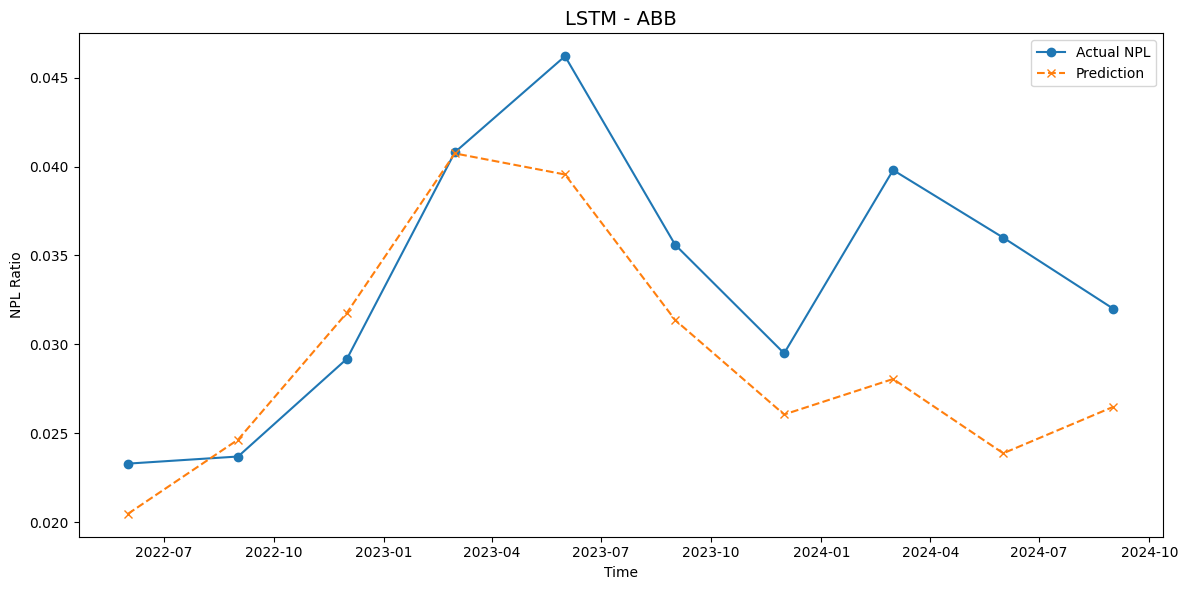

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
LSTM - OCB | MAE: 0.0031, MSE: 0.0000, RMSE: 0.0037, R²: 0.4956, SMAPE: 11.50%, MASE: 0.6661


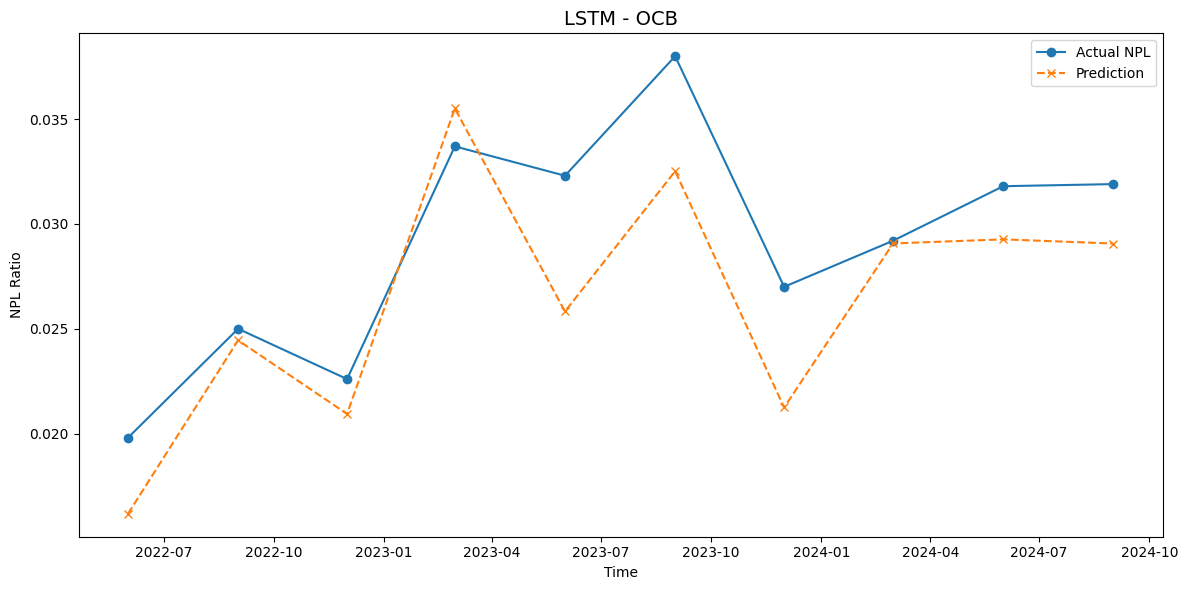

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
LSTM - SHB | MAE: 0.0028, MSE: 0.0000, RMSE: 0.0034, R²: -0.7126, SMAPE: 10.09%, MASE: 1.8792


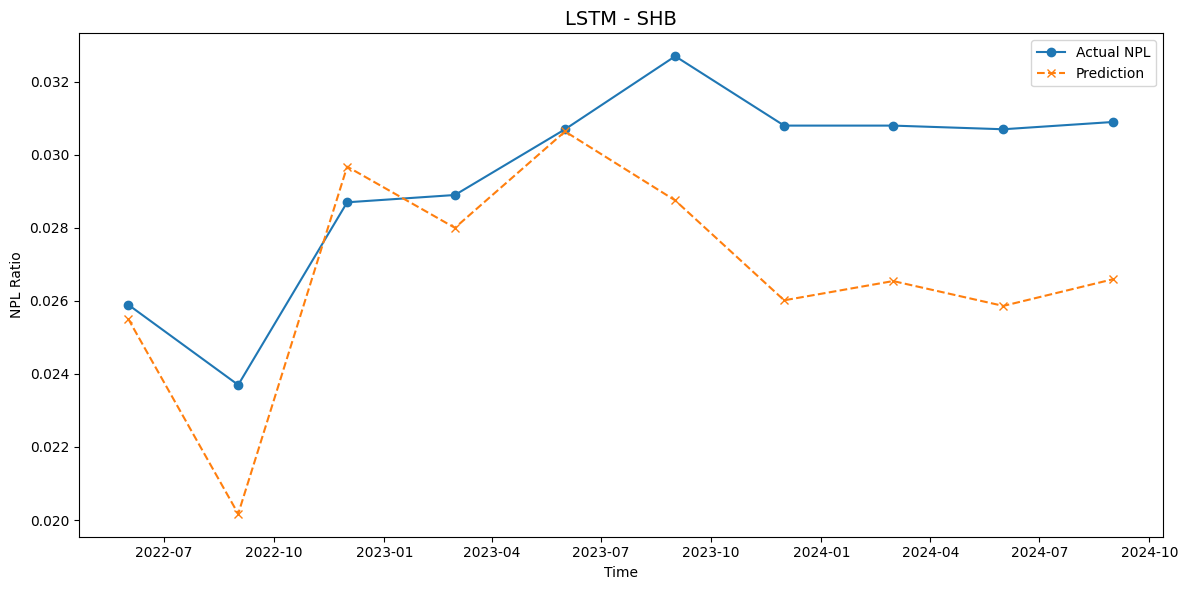

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
LSTM - VCB | MAE: 0.0135, MSE: 0.0002, RMSE: 0.0139, R²: -36.0497, SMAPE: 81.89%, MASE: 8.5985


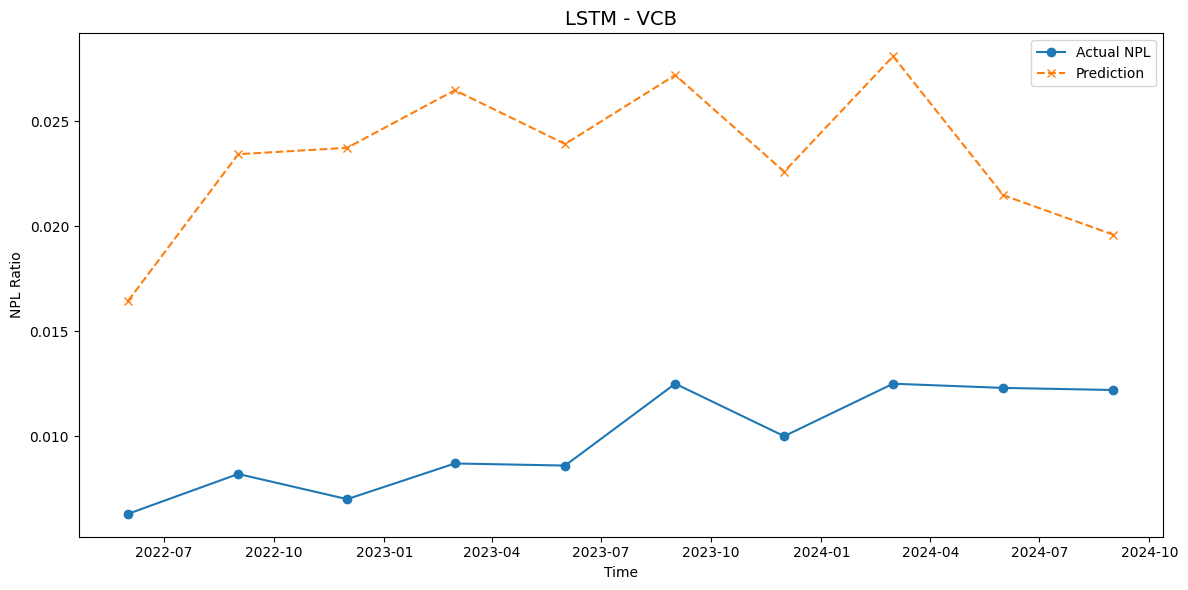

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
LSTM - BID | MAE: 0.0029, MSE: 0.0000, RMSE: 0.0039, R²: -2.6475, SMAPE: 17.37%, MASE: 1.4873


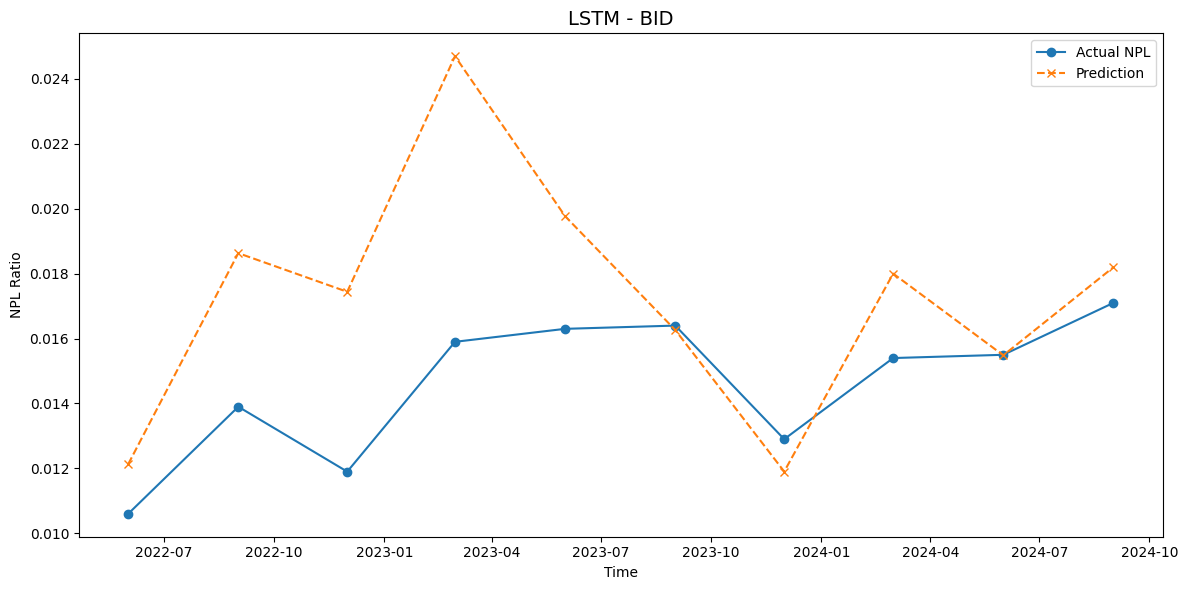

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
LSTM - VPB | MAE: 0.0254, MSE: 0.0007, RMSE: 0.0260, R²: -17.3986, SMAPE: 58.68%, MASE: 5.4598


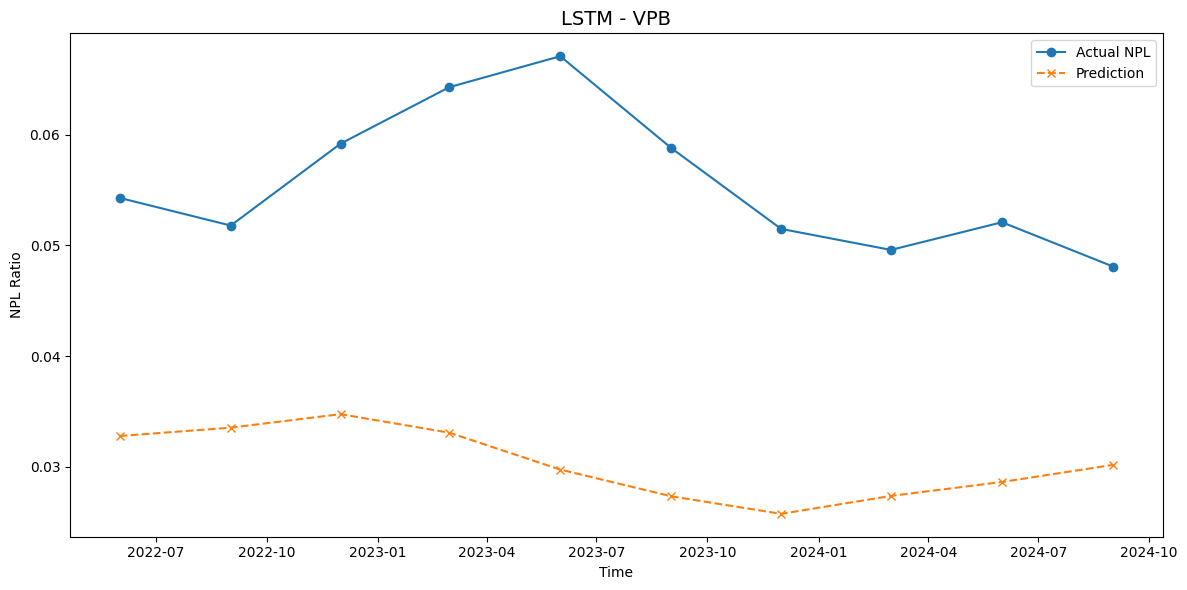

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
LSTM - MBB | MAE: 0.0041, MSE: 0.0000, RMSE: 0.0050, R²: -1.7865, SMAPE: 20.12%, MASE: 1.6554


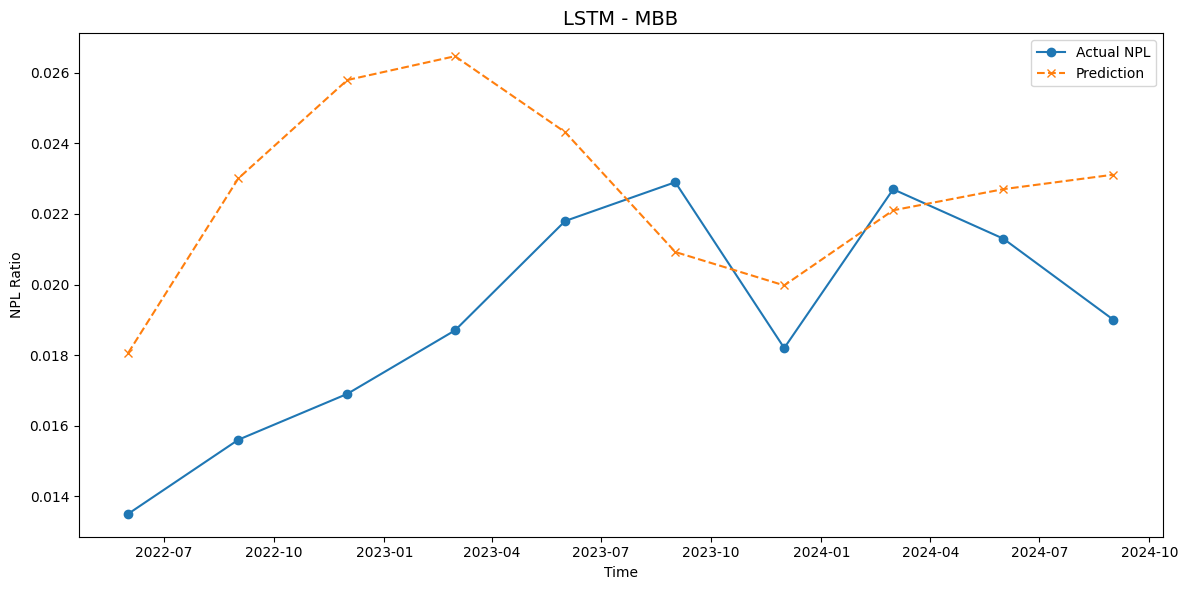

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
LSTM - SSB | MAE: 0.0031, MSE: 0.0000, RMSE: 0.0041, R²: -6.3191, SMAPE: 18.91%, MASE: 5.5517


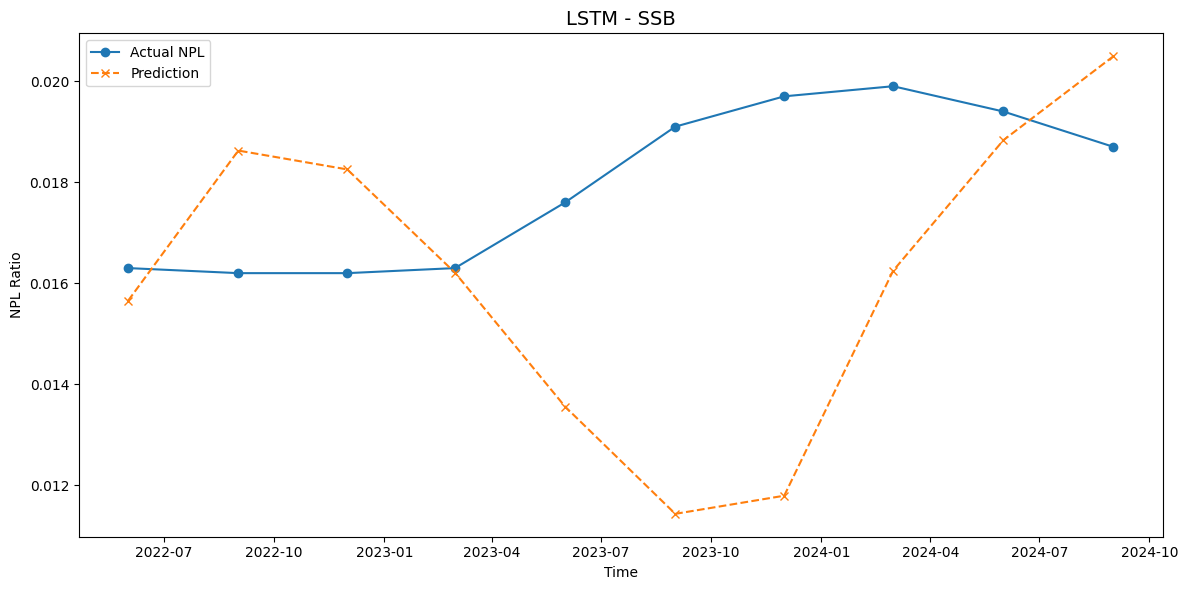

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
LSTM - BAB | MAE: 0.0077, MSE: 0.0001, RMSE: 0.0097, R²: -8.2930, SMAPE: 61.53%, MASE: 5.2335


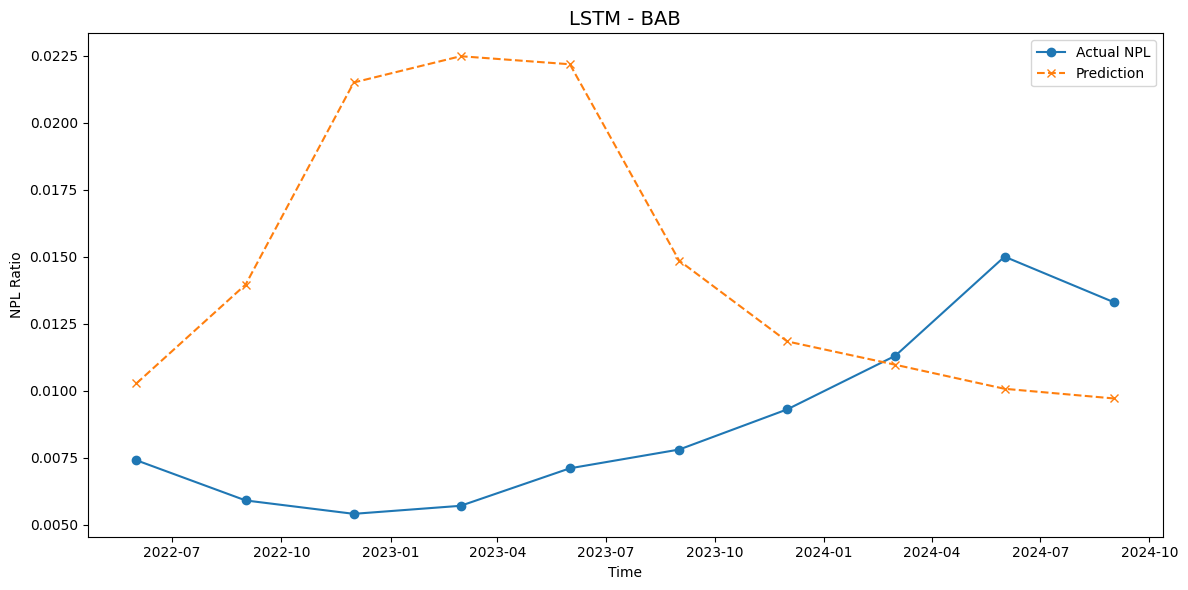

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
LSTM - VIB | MAE: 0.0095, MSE: 0.0001, RMSE: 0.0101, R²: -2.0646, SMAPE: 32.65%, MASE: 3.2173


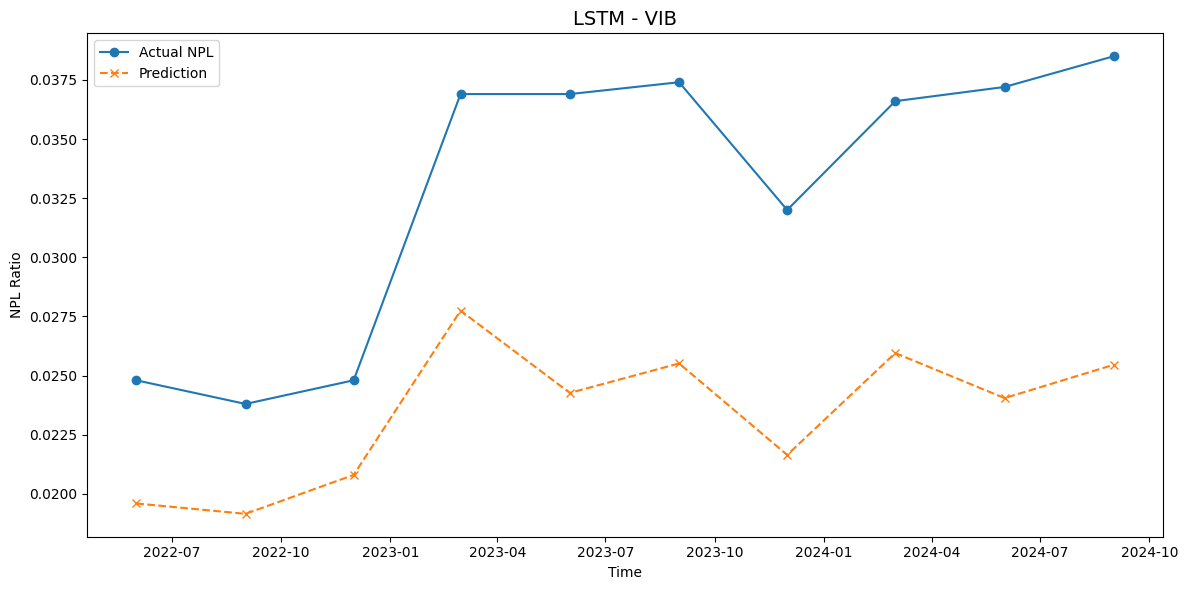

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
LSTM - VBB | MAE: 0.0060, MSE: 0.0001, RMSE: 0.0071, R²: -0.7290, SMAPE: 17.79%, MASE: 1.0962


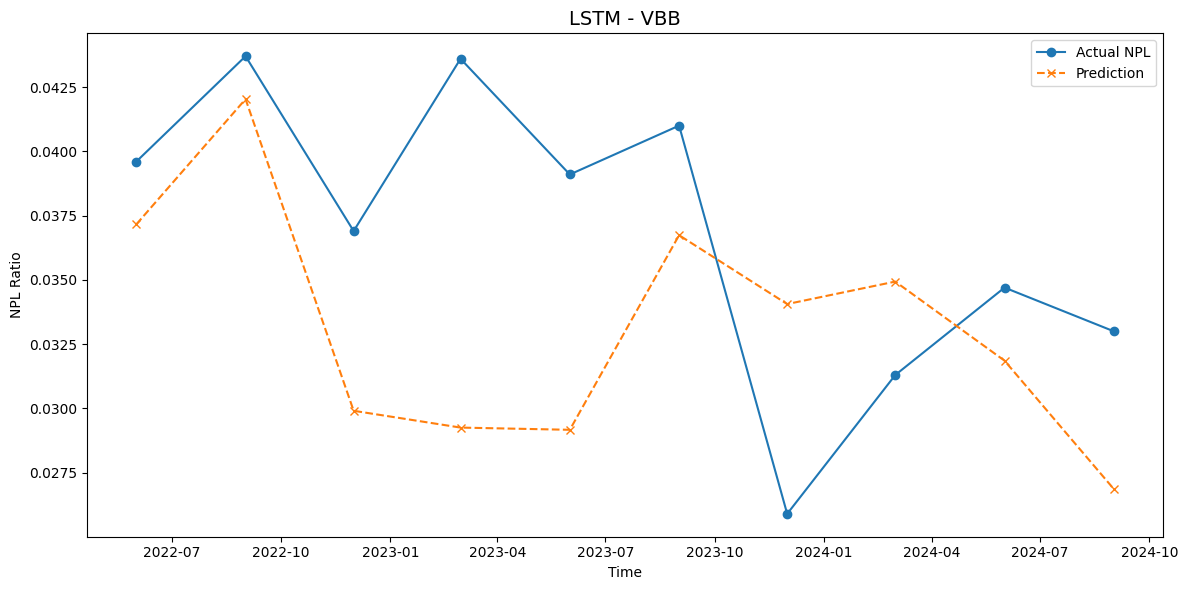

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
LSTM - PGB | MAE: 0.0063, MSE: 0.0001, RMSE: 0.0071, R²: -3.8135, SMAPE: 26.10%, MASE: 1.7110


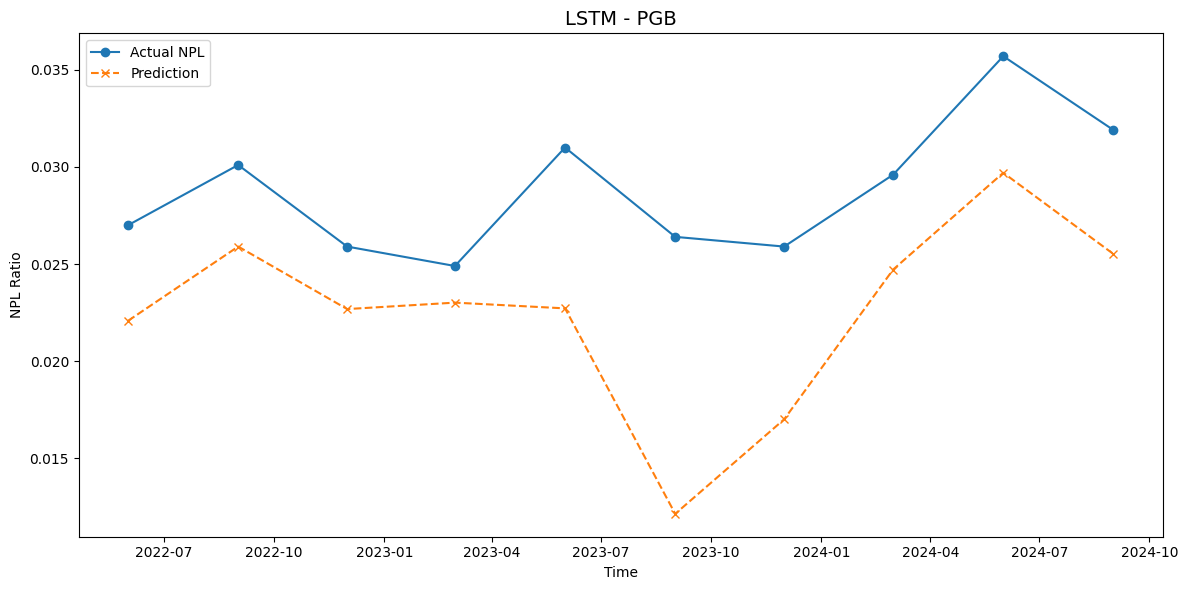

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
LSTM - CTG | MAE: 0.0017, MSE: 0.0000, RMSE: 0.0021, R²: -2.1512, SMAPE: 12.69%, MASE: 1.1841


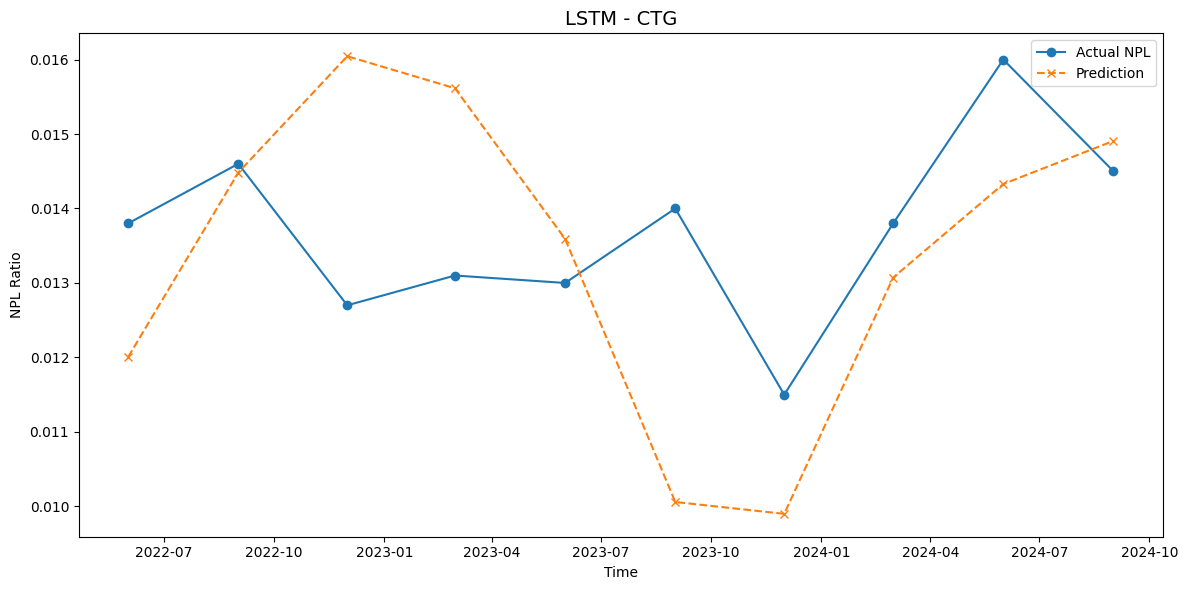

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
LSTM - SGB | MAE: 0.0083, MSE: 0.0001, RMSE: 0.0095, R²: -12.6767, SMAPE: 30.16%, MASE: 4.6910


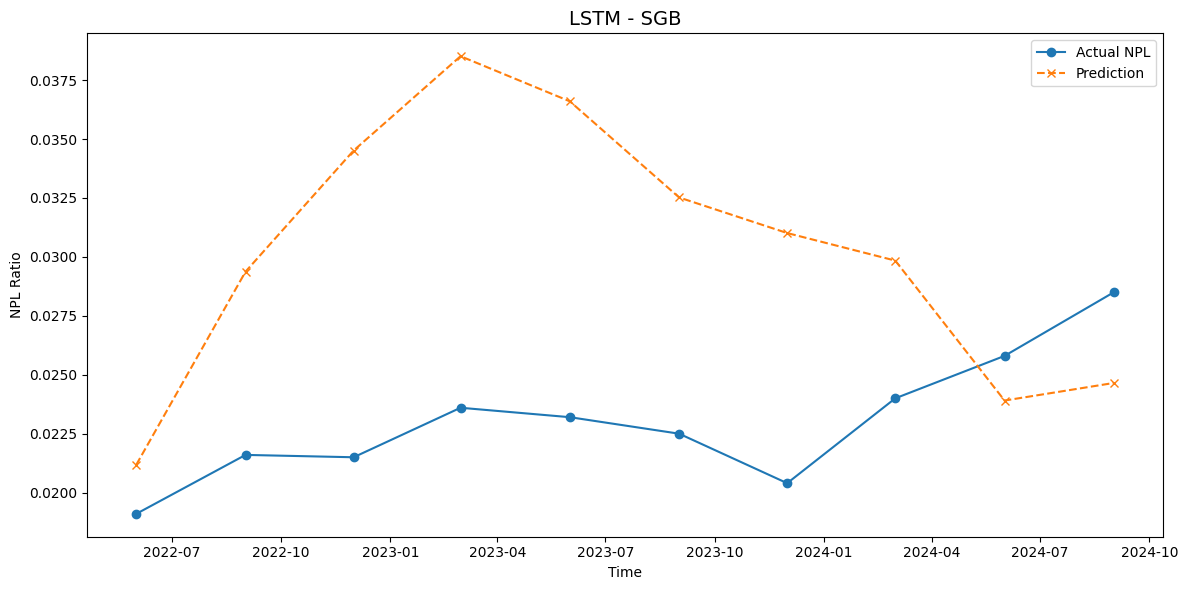

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
LSTM - TPB | MAE: 0.0065, MSE: 0.0001, RMSE: 0.0080, R²: -0.2844, SMAPE: 37.80%, MASE: 1.5446


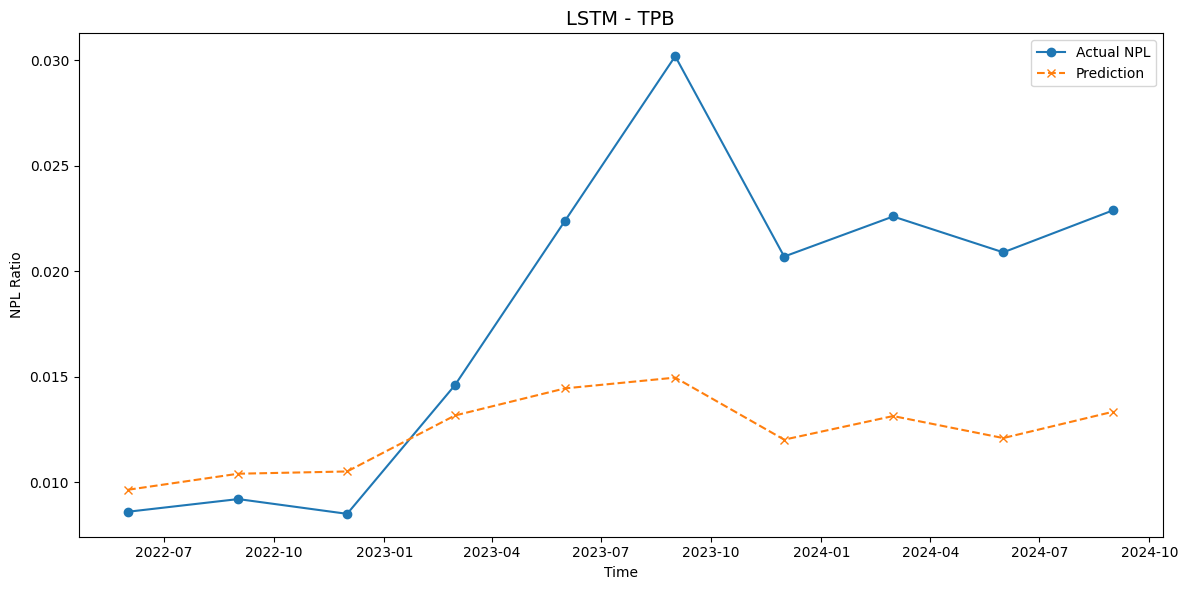

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
LSTM - EIB | MAE: 0.0021, MSE: 0.0000, RMSE: 0.0025, R²: 0.5667, SMAPE: 8.97%, MASE: 1.1556


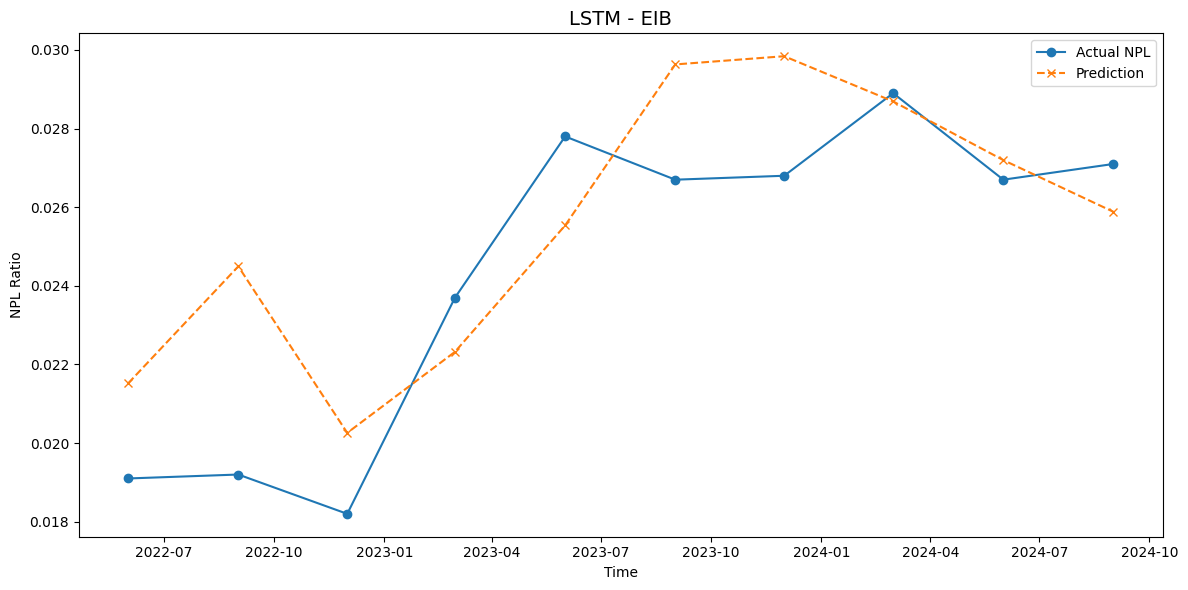

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
LSTM - NAB | MAE: 0.0046, MSE: 0.0000, RMSE: 0.0054, R²: 0.0010, SMAPE: 21.46%, MASE: 0.9117


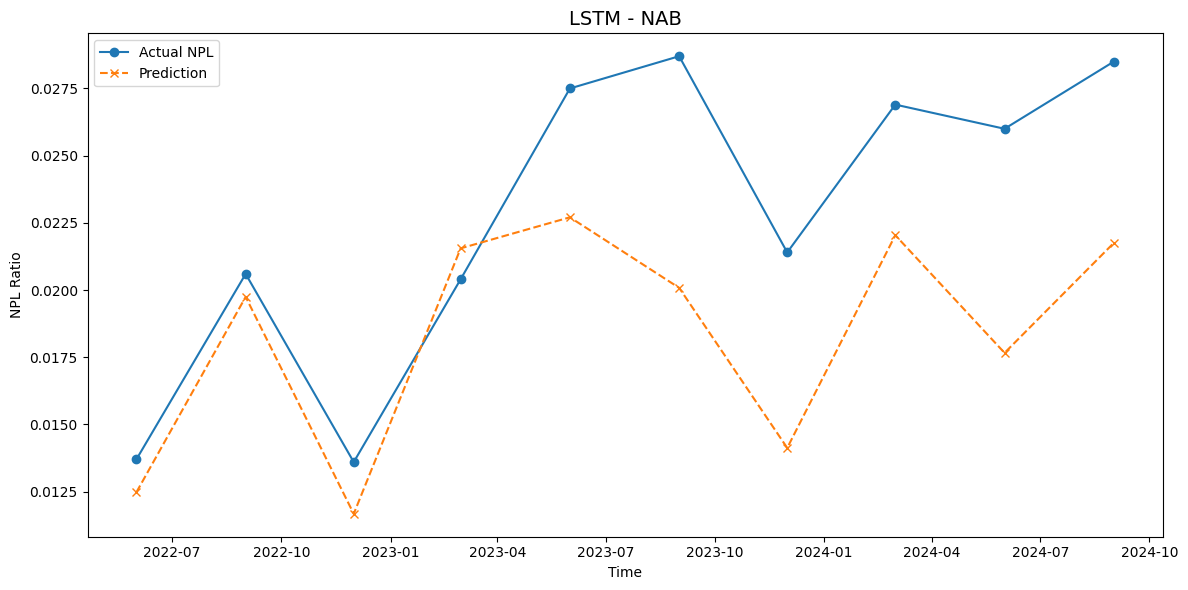

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
LSTM - KLB | MAE: 0.0040, MSE: 0.0000, RMSE: 0.0047, R²: -4.3932, SMAPE: 20.42%, MASE: 1.7123


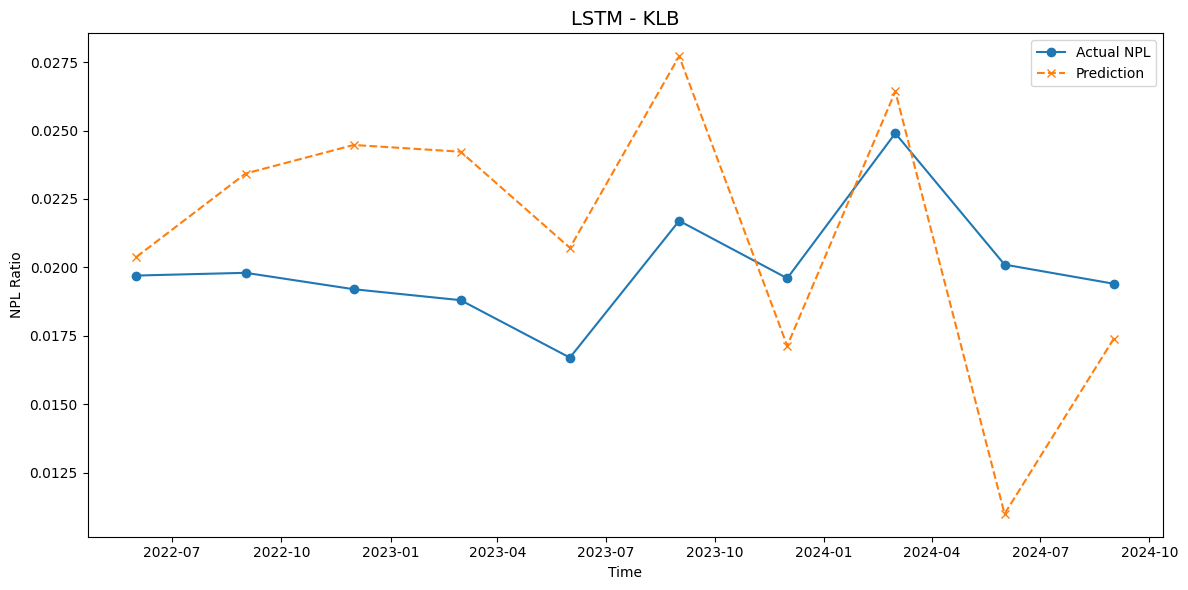

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
LSTM - STB | MAE: 0.0121, MSE: 0.0002, RMSE: 0.0133, R²: -3.8381, SMAPE: 54.00%, MASE: 5.5855


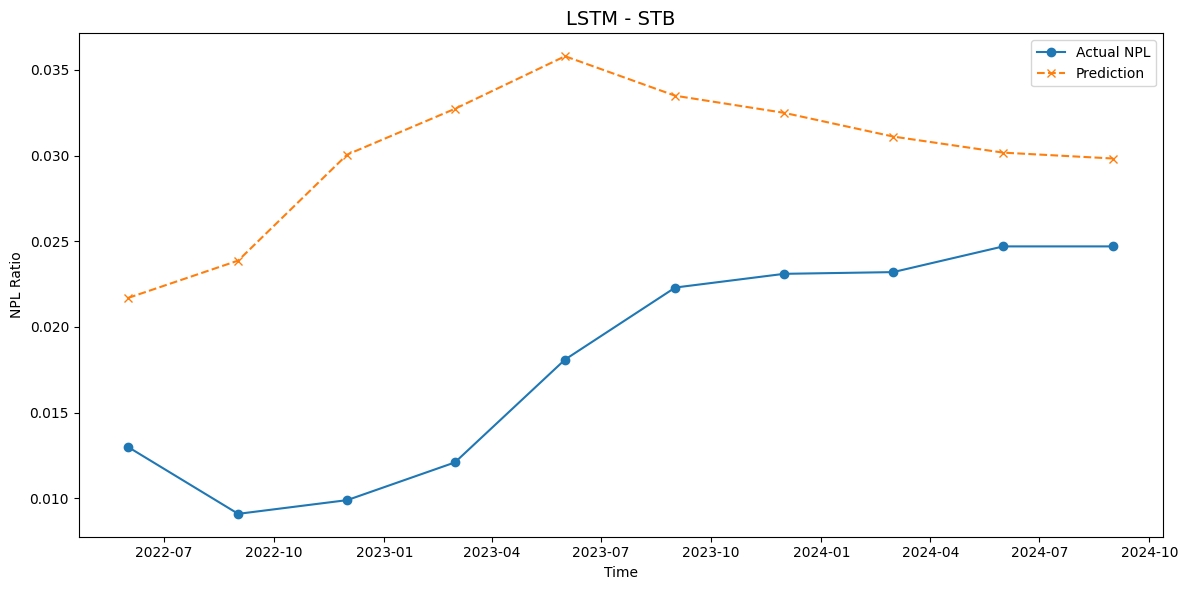

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
LSTM - TCB | MAE: 0.0029, MSE: 0.0000, RMSE: 0.0034, R²: -0.8222, SMAPE: 31.99%, MASE: 2.0355


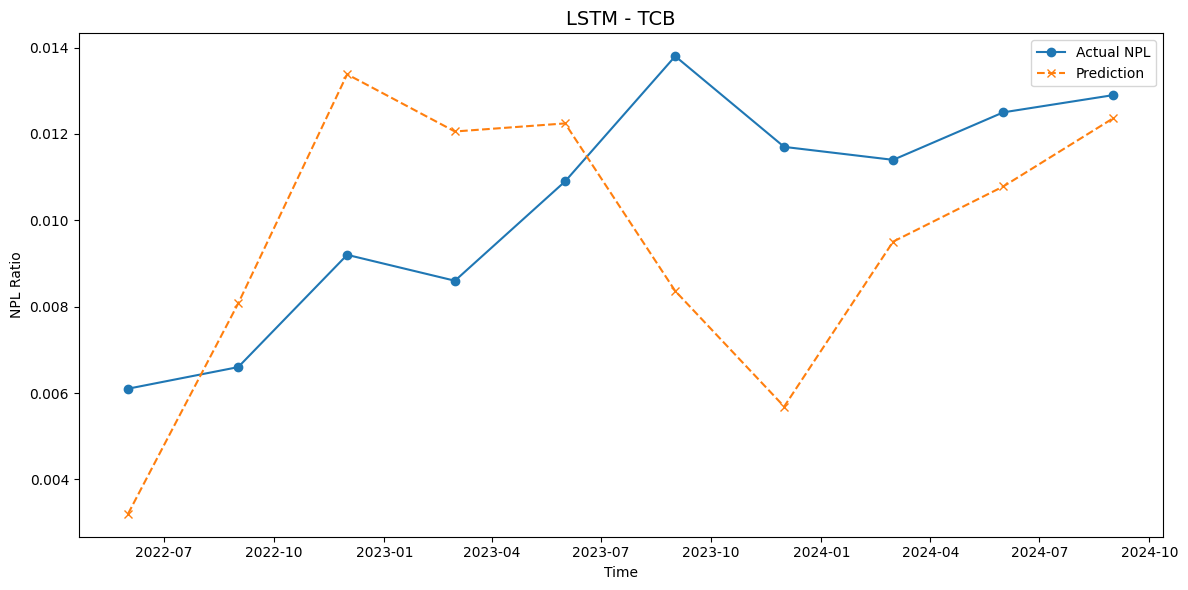

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
LSTM - HDB | MAE: 0.0037, MSE: 0.0000, RMSE: 0.0046, R²: -0.0470, SMAPE: 30.67%, MASE: 0.7792


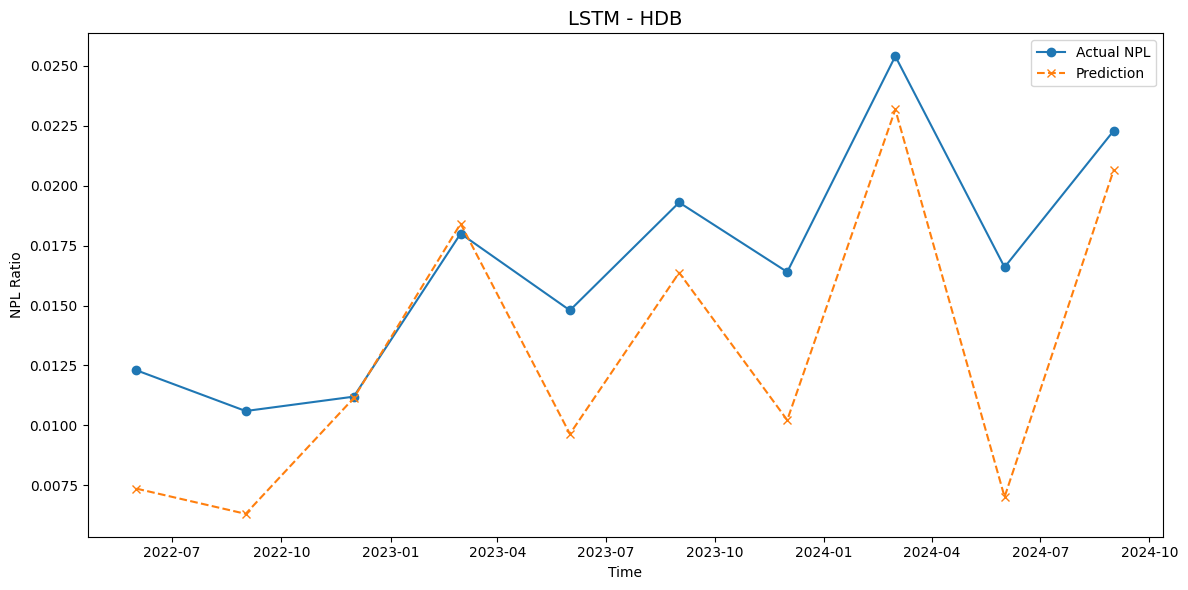

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
LSTM - ACB | MAE: 0.0026, MSE: 0.0000, RMSE: 0.0033, R²: -0.5240, SMAPE: 21.87%, MASE: 1.7966


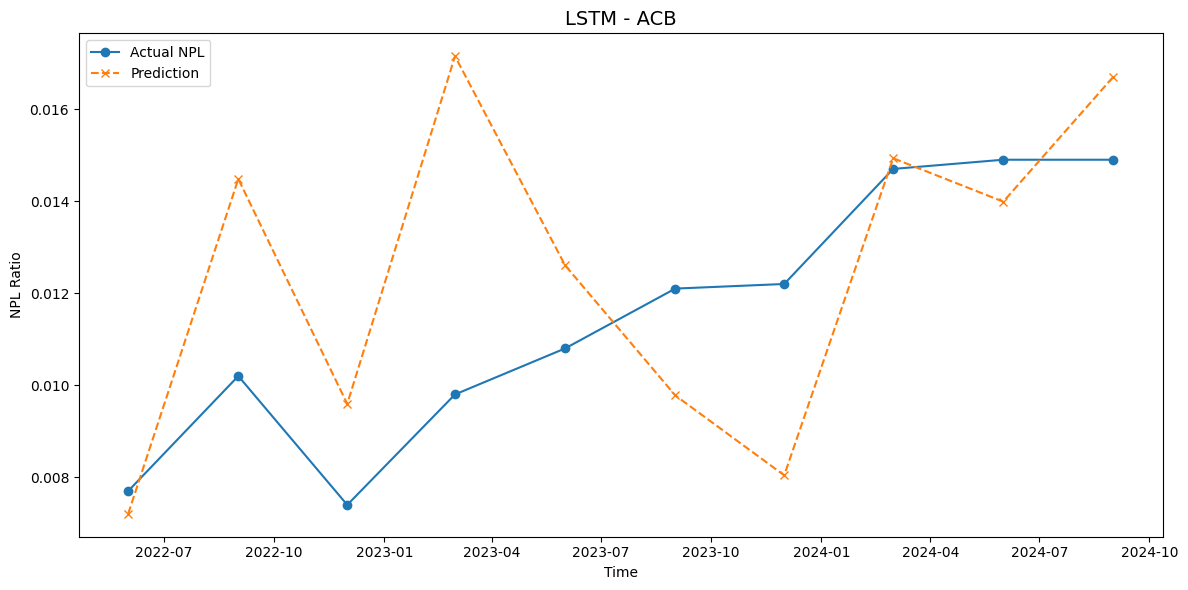

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
LSTM - MSB | MAE: 0.0061, MSE: 0.0000, RMSE: 0.0065, R²: 0.0033, SMAPE: 26.03%, MASE: 2.4836


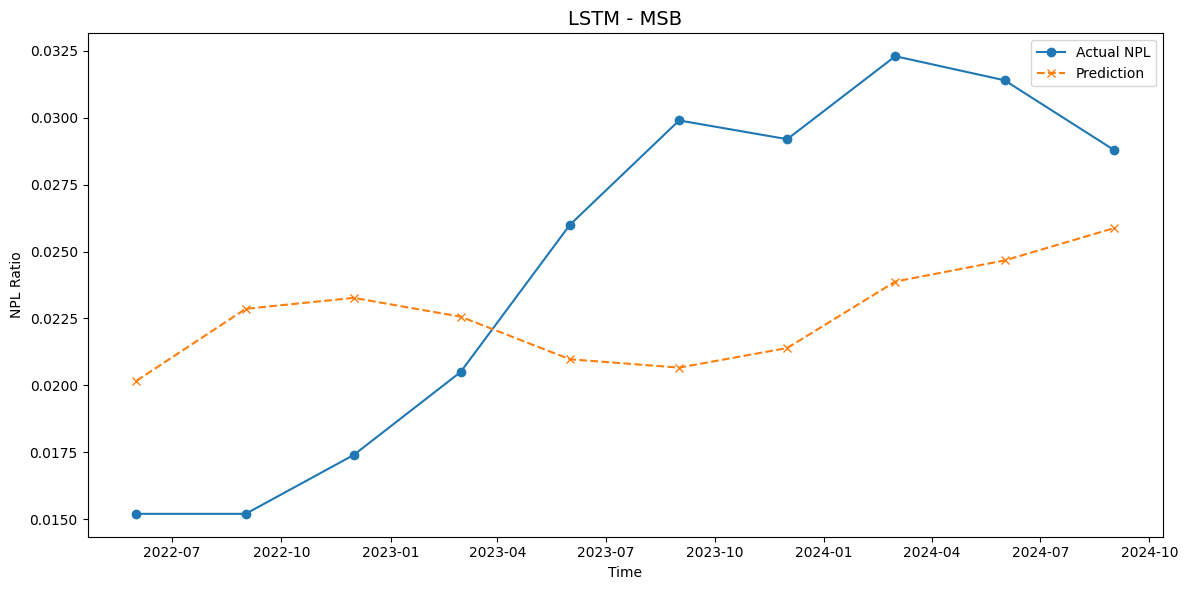

In [20]:
dl_models, evals = run_lstm_with_best_params(train_df, test_df, best_params_dict, epochs=100, batch_size=16)

In [22]:
# Convert evaluation results into a DataFrame
eval_results_df = pd.DataFrame(eval_results, columns=["Bank", "Model", "MAE", "MSE", "RMSE", "R2", "SMAPE", "MASE"])

# Display results
display(eval_results_df)

,Bank,Model,MAE,MSE,RMSE,R2,SMAPE,MASE
0,ABB,LSTM,0.003170,0.000016,0.003997,0.681485,9.375620,0.494427
1,OCB,LSTM,0.009941,0.000112,0.010568,-3.050898,42.494847,2.145618
2,SHB,LSTM,0.004565,0.000023,0.004819,-2.523028,16.869090,3.066071
3,VCB,LSTM,0.005293,0.000045,0.006689,-7.617817,77.206656,3.378588
4,BID,LSTM,0.003499,0.000015,0.003874,-2.556875,28.546581,1.799585
5,VPB,LSTM,0.008394,0.000097,0.009849,-1.632384,17.387350,1.807250
6,MBB,LSTM,0.001938,0.000005,0.002132,0.488970,9.772578,0.782075
7,SSB,LSTM,0.004366,0.000022,0.004682,-8.724887,21.669094,7.858549
8,BAB,LSTM,0.002829,0.000010,0.003188,-0.010318,31.633210,1.914433
9,VIB,LSTM,0.008064,0.000083,0.009122,-1.516598,26.199108,2.738766


In [23]:
top5_tuned = get_top_banks(eval_results_df, metric="MASE", top_n=5)
display(top5_tuned)

,Bank,Model,MAE,MSE,RMSE,R2,SMAPE,MASE
0,ABB,LSTM,0.003170,0.000016,0.003997,0.681485,9.375620,0.494427
21,ACB,LSTM,0.001074,0.000003,0.001647,0.615252,10.432424,0.755070
6,MBB,LSTM,0.001938,0.000005,0.002132,0.488970,9.772578,0.782075
20,HDB,LSTM,0.003846,0.000020,0.004508,0.013641,22.680169,0.801180
12,CTG,LSTM,0.001339,0.000003,0.001783,-1.346906,10.771186,0.949235


In [24]:
best_model_tuned = eval_results_df.sort_values(by=["Bank", "MASE"]).groupby("Bank").first().reset_index()
display(best_model_tuned)

,Bank,Model,MAE,MSE,RMSE,R2,SMAPE,MASE
0,ABB,LSTM,0.003170,0.000016,0.003997,0.681485,9.375620,0.494427
1,ACB,LSTM,0.001074,0.000003,0.001647,0.615252,10.432424,0.755070
2,BAB,LSTM,0.002829,0.000010,0.003188,-0.010318,31.633210,1.914433
3,BID,LSTM,0.003499,0.000015,0.003874,-2.556875,28.546581,1.799585
4,CTG,LSTM,0.001339,0.000003,0.001783,-1.346906,10.771186,0.949235
5,EIB,LSTM,0.002515,0.000009,0.003070,0.369572,10.342952,1.363346
6,HDB,LSTM,0.003846,0.000020,0.004508,0.013641,22.680169,0.801180
7,KLB,LSTM,0.003654,0.000022,0.004701,-4.453419,19.040586,1.558740
8,MBB,LSTM,0.001938,0.000005,0.002132,0.488970,9.772578,0.782075
9,MSB,LSTM,0.007440,0.000088,0.009383,-1.097414,33.024503,3.043685


In [25]:
file_name = "dl_results.xlsx"

with pd.ExcelWriter(file_name, engine="xlsxwriter") as writer:
    dl_results_df.to_excel(writer, sheet_name="Basic", index=False)
    best_model.to_excel(writer, sheet_name="Basic best", index=False)
    eval_results_df.to_excel(writer, sheet_name="Tuned", index=False)
    best_model_tuned.to_excel(writer, sheet_name="Best tuned", index=False)